In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from numpy import pi

PosVel_read = open('Velocidad.txt','r')

PosVel_split = [line.split(',') for line in PosVel_read.readlines()]


#Feature extraction for both velocity and position
iteration = 0 #Iteration
rcount = 1    #Row number

while rcount <len(PosVel_split):
    
    if iteration==0:
        if (rcount-(6*iteration))==1:
            Vel_array = np.array([PosVel_split[rcount][11],
                                  PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15]])
    
        elif (rcount-(6*iteration))==4:
            Pos_array = np.array([PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15],
                                  PosVel_split[rcount][18],
                                  PosVel_split[rcount][19],
                                  PosVel_split[rcount][20]])
            iteration += 1
            
    else:
        if (rcount-(6*iteration))==1:
            Vel_array = np.vstack([Vel_array,[PosVel_split[rcount][11],
                                  PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15]]])
    
        elif (rcount-(6*iteration))==4:
            Pos_array = np.vstack([Pos_array,[PosVel_split[rcount][13],
                                  PosVel_split[rcount][14],
                                  PosVel_split[rcount][15],
                                  PosVel_split[rcount][18],
                                  PosVel_split[rcount][19],
                                  PosVel_split[rcount][20]]])
            iteration += 1
            
            
    rcount+=3
    
#Conversion to type float64
    
Pos_array = Pos_array.astype('float64')
Vel_array = Vel_array.astype('float64')


#Data cleaning - Data that equals to zero must be removed, in this case we have 3 bad data points

iteration = 0
a = []

while iteration<len(Pos_array):

    if (Pos_array[iteration][0]==0.0) or (Pos_array[iteration][1]==0.0):  #We detect North or East equal to zero     
        a.append(iteration)

    iteration +=1
    
Pos_array = np.delete(Pos_array,a,0)
Vel_array = np.delete(Vel_array,a,0)



#Data Frame Creation

Pos_DataFrame = pd.DataFrame(Pos_array,[np.arange(0,len(Pos_array))],['North','East','Height','N_dev','E_dev'
                                                            ,'Hei_dev'])

Vel_DataFrame = pd.DataFrame(Vel_array,[np.arange(0,len(Pos_array))],['Latency','Hspeed','TrackDir','Vspeed'])


#Add total speed. We set if it is 2D or 3D mode

Mode_3D = False    

Vel_DataFrame['Total_Speed'] = ((Vel_DataFrame['Hspeed']**2)+(Mode_3D*Vel_DataFrame['Vspeed']**2))**(1/2)


#Vector

Vector = Pos_DataFrame[['North','East']]
Vector['Total_Speed'] = Vel_DataFrame['Total_Speed']

Vector_array = Vector.to_numpy()


#Vector_errors

Vector_errors = Pos_DataFrame[['N_dev','E_dev']]
Vector_errors['Vel_dev'] = 0

Vector_err_array = Vector_errors.to_numpy()



# KALMAN FILTER STARTS HERE
#We construct the different matrices and the initial state

measurements = len(Pos_array)
dt = Vel_array.mean(axis=0)[0]

alpha = Vel_array[0][2]*(pi/180)
state = np.array([[Vector_array[0][0]],[Vector_array[0][1]],[0],[0]])  #Initial state

A = np.array([[1.0,0.0,dt,0.0],                    #Transformation Matrix
              [0.0,1.0,0.0,dt],
              [0.0,0.0,1.0,0.0],
              [0.0,0.0,0.0,1.0]])

B = np.array([[0,0,35000,0],              #Noise matrix
              [0,0,0,15000],
              [0,0,1,0],
              [0,0,0,1]])

B = B*((10)**(-6))

P = (np.diag([Vector_err_array[0][0],Vector_err_array[0][1],1,1]))**2         #Initial state covariance

factor = 8.8
G = np.array([[0.5*(dt**2)],[0.5*(dt**2)],[1*dt],[1*dt]])
Q = (G@G.T)*((factor)**2)

H = np.array([[0,0,1,0],             #Measurement observation matrix
              [0,0,0,1]])

R = np.array([[1,0],
              [0,1]])

I = np.eye(4)




#ACTION!!

for epoch in range(measurements):
  
    
    #PREDICTION
    
    state = A@state + B@state

    P = A@P@A.T + Q
     
    
    #CORRECTION
    
    S = H@P@H.T + R 
    K = P@H.T@np.linalg.inv(S)
    
    alpha = Vel_array[epoch][2]*(pi/180)
    Z = np.array([[Vector_array[epoch][2]*(np.sin((pi/2)-alpha))],
                  [Vector_array[epoch][2]*(np.cos((pi/2)-alpha))]])
    state = state + (K@(Z - H@state))
    
    P = (I - (K@H))@P
    
    
    #PLOTTING
    
    if epoch==0:      
        Prediction_array = np.array([state[0][0],state[1][0]])
        #Parameters_array = np.array([K[0][0],K[1][1],K[2][2]])
        
    else: 
        Prediction_array = np.vstack([Prediction_array,[state[0][0],state[1][0]]])
        #Parameters_array = np.vstack([Parameters_array,[K[0][0],K[1][1],K[2][2]]])
    
    
    
    
    
#We create a DataFrame of the results.
    
Prediction_DataFrame = pd.DataFrame(Prediction_array,[np.arange(0,len(Prediction_array))],['North_Prediction(x)', 'South_Prediction(y)'])
#Parameters_DataFrame = pd.DataFrame(Parameters_array,[np.arange(0,len(Parameters_array))],['Kx','Ky','Kv'])


C:\Users\manu-\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\manu-\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


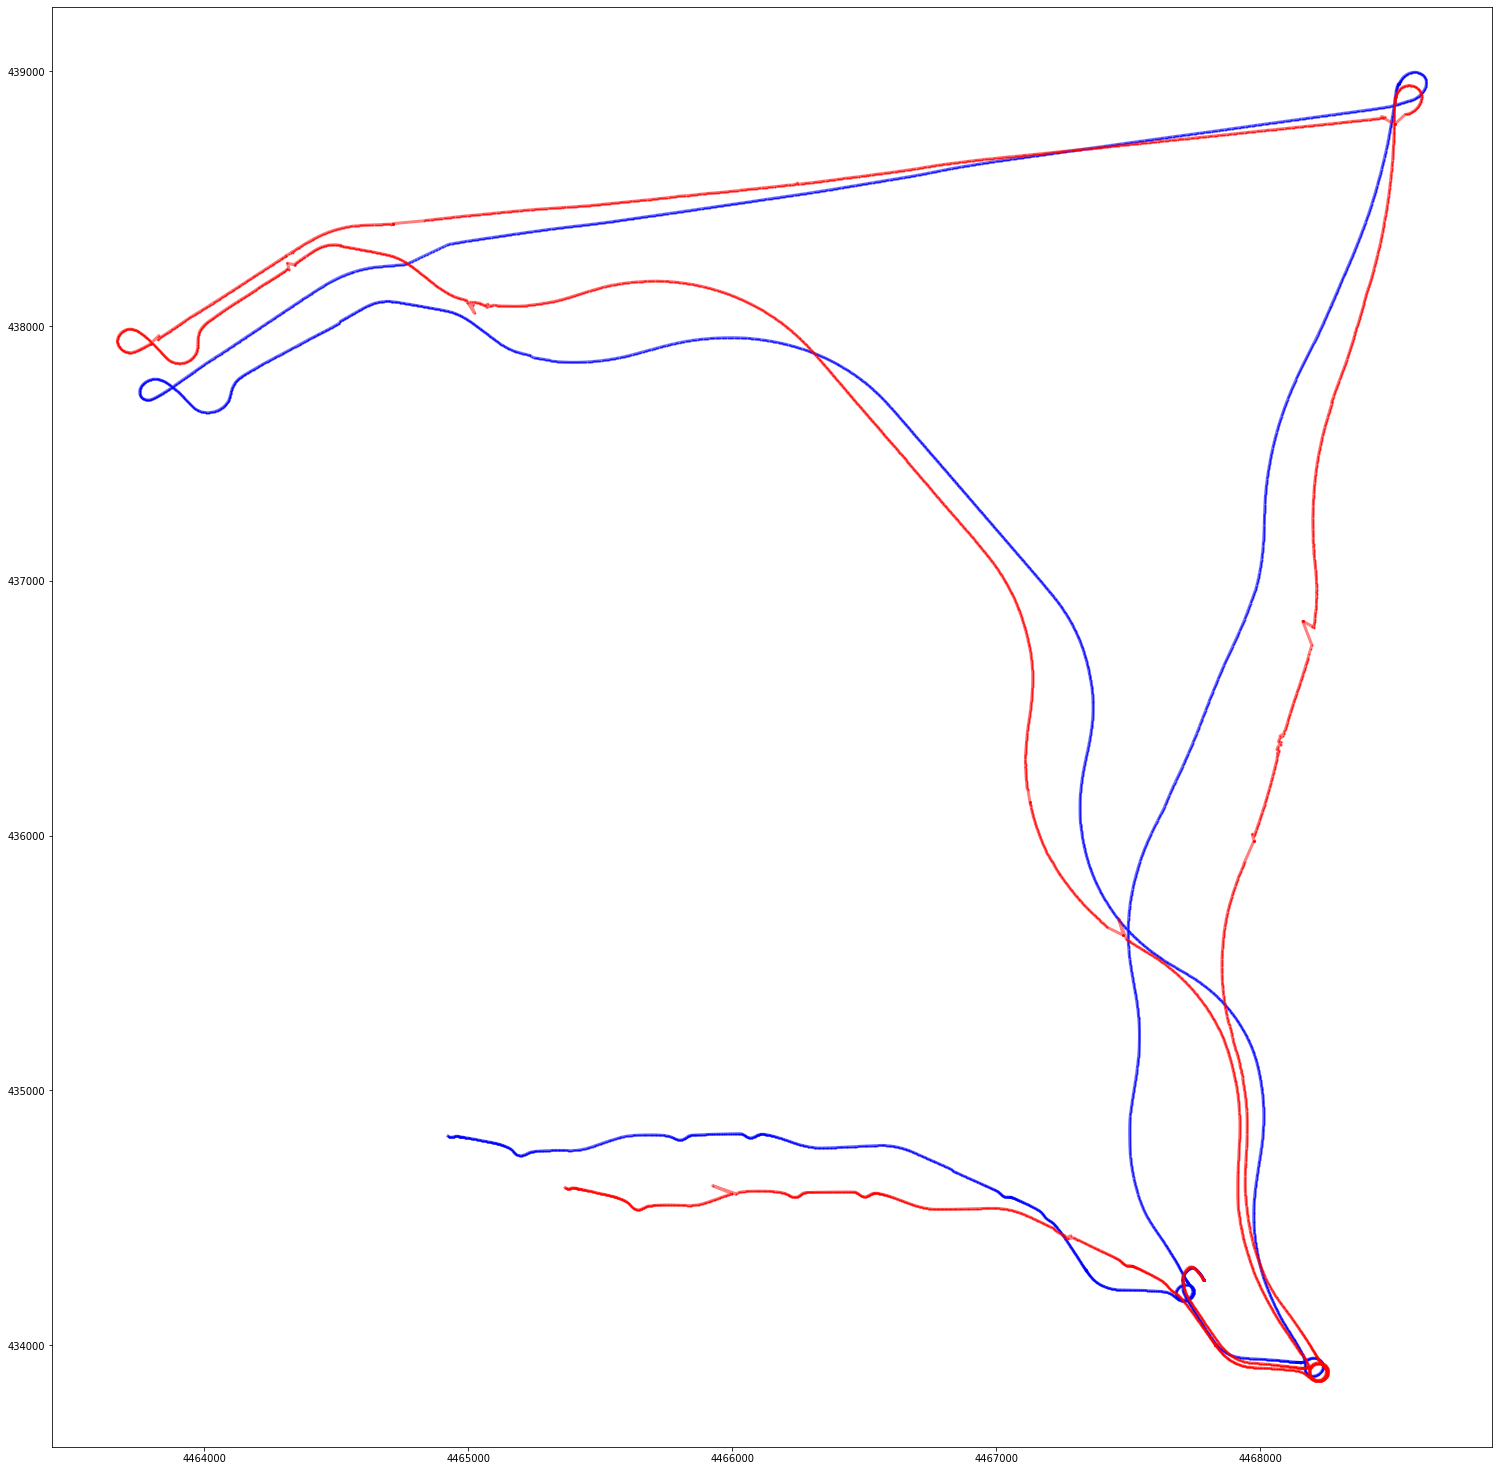

In [2]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame['North_Prediction(x)'],Prediction_DataFrame['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=1,label='Prediction')
ax.plot(Pos_DataFrame['North'],Pos_DataFrame['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=1,label='Data')

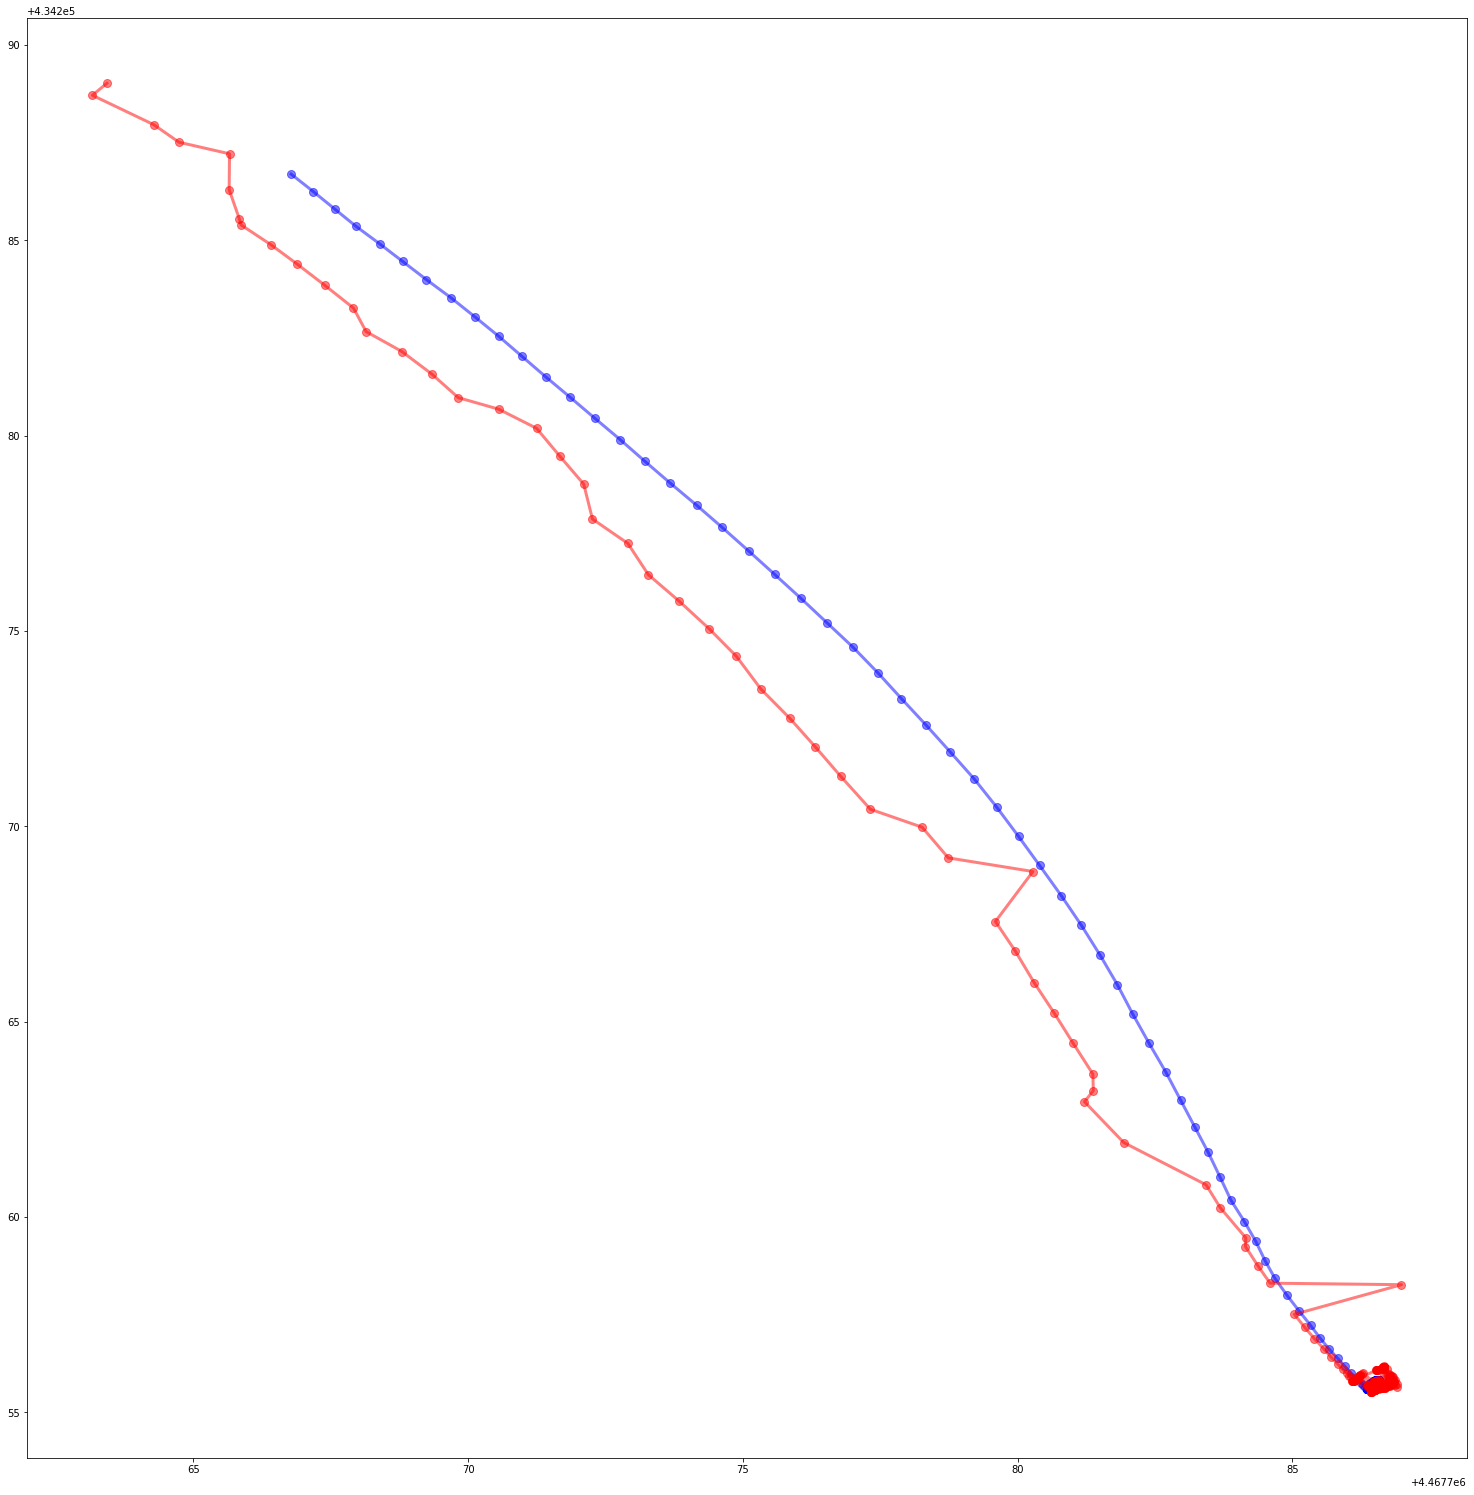

In [10]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[0:400]['North_Prediction(x)'],Prediction_DataFrame[0:400]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[0:400]['North'],Pos_DataFrame[0:400]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

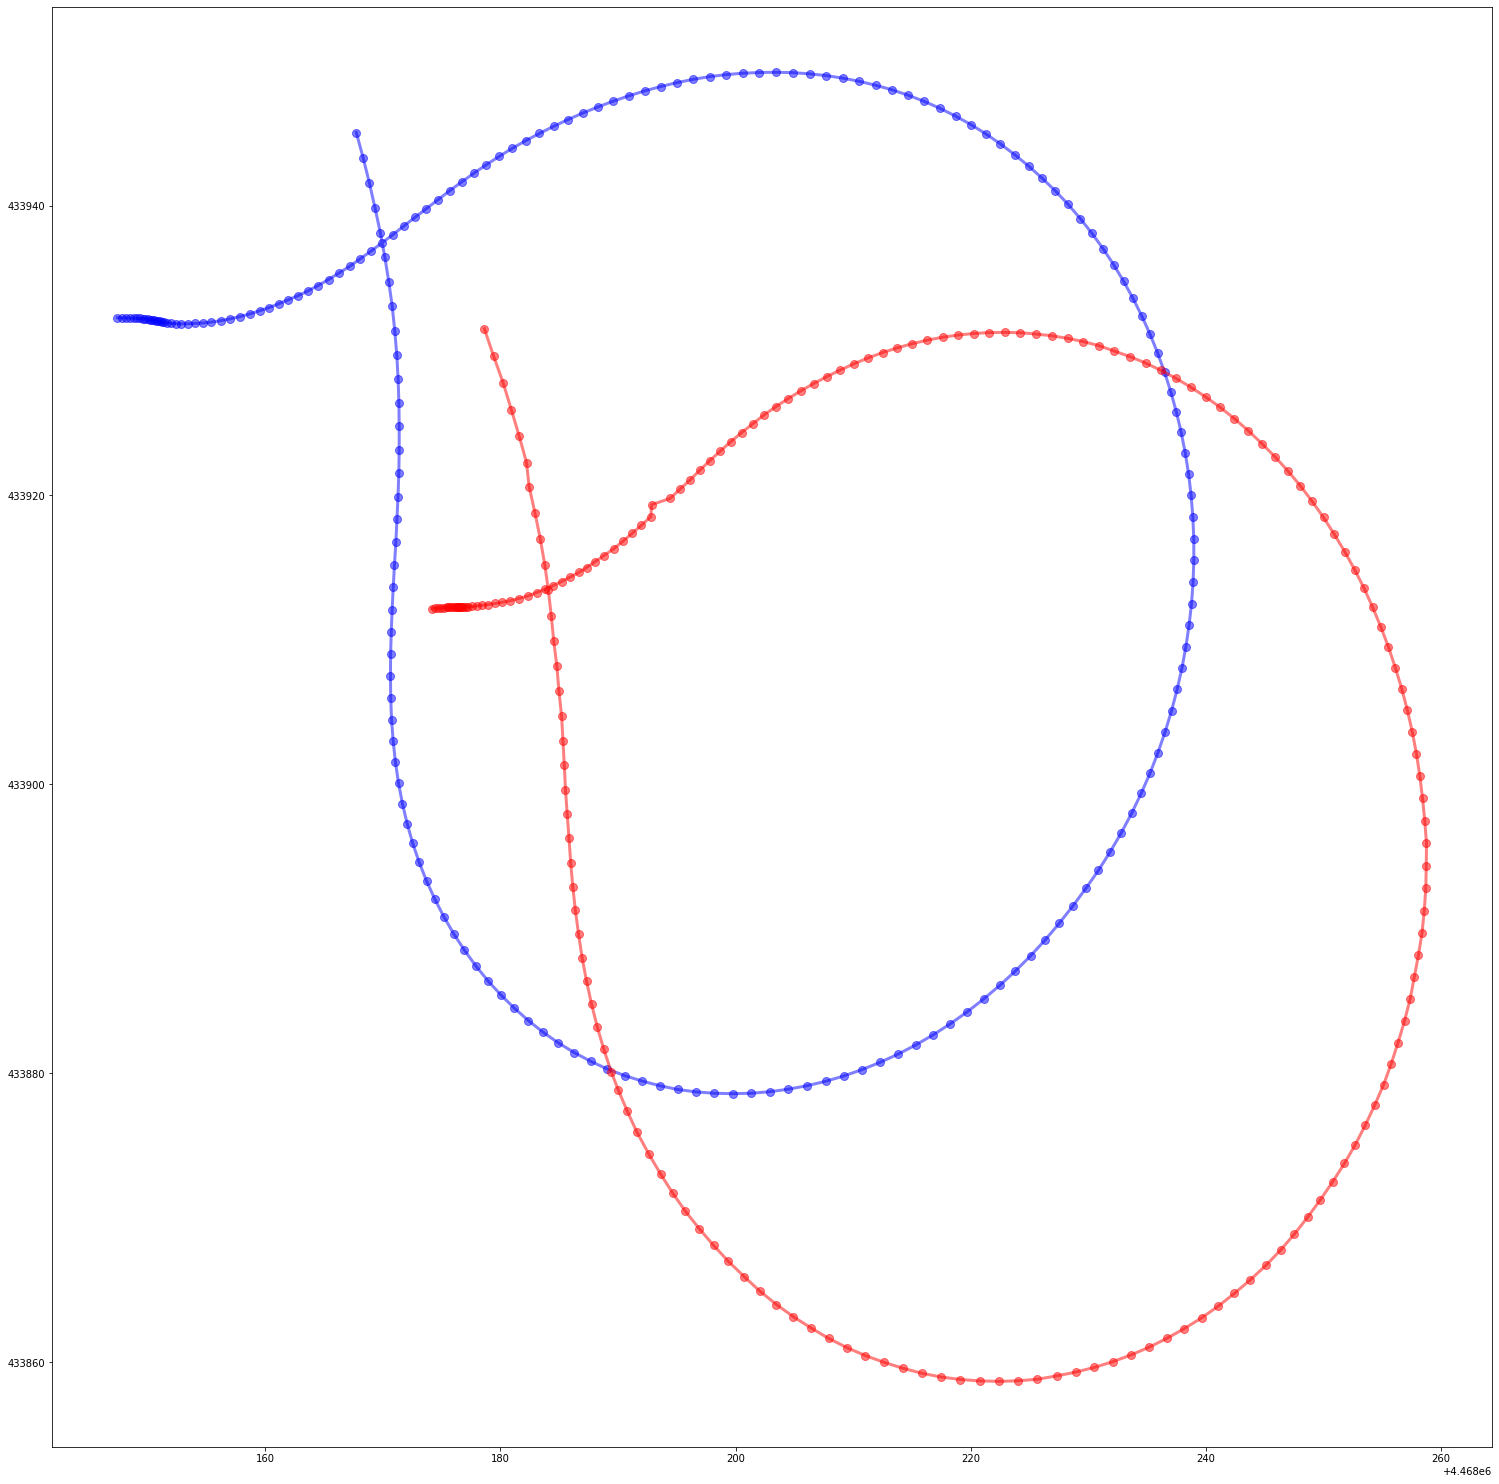

In [7]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[800:1000]['North_Prediction(x)'],Prediction_DataFrame[800:1000]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[800:1000]['North'],Pos_DataFrame[800:1000]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

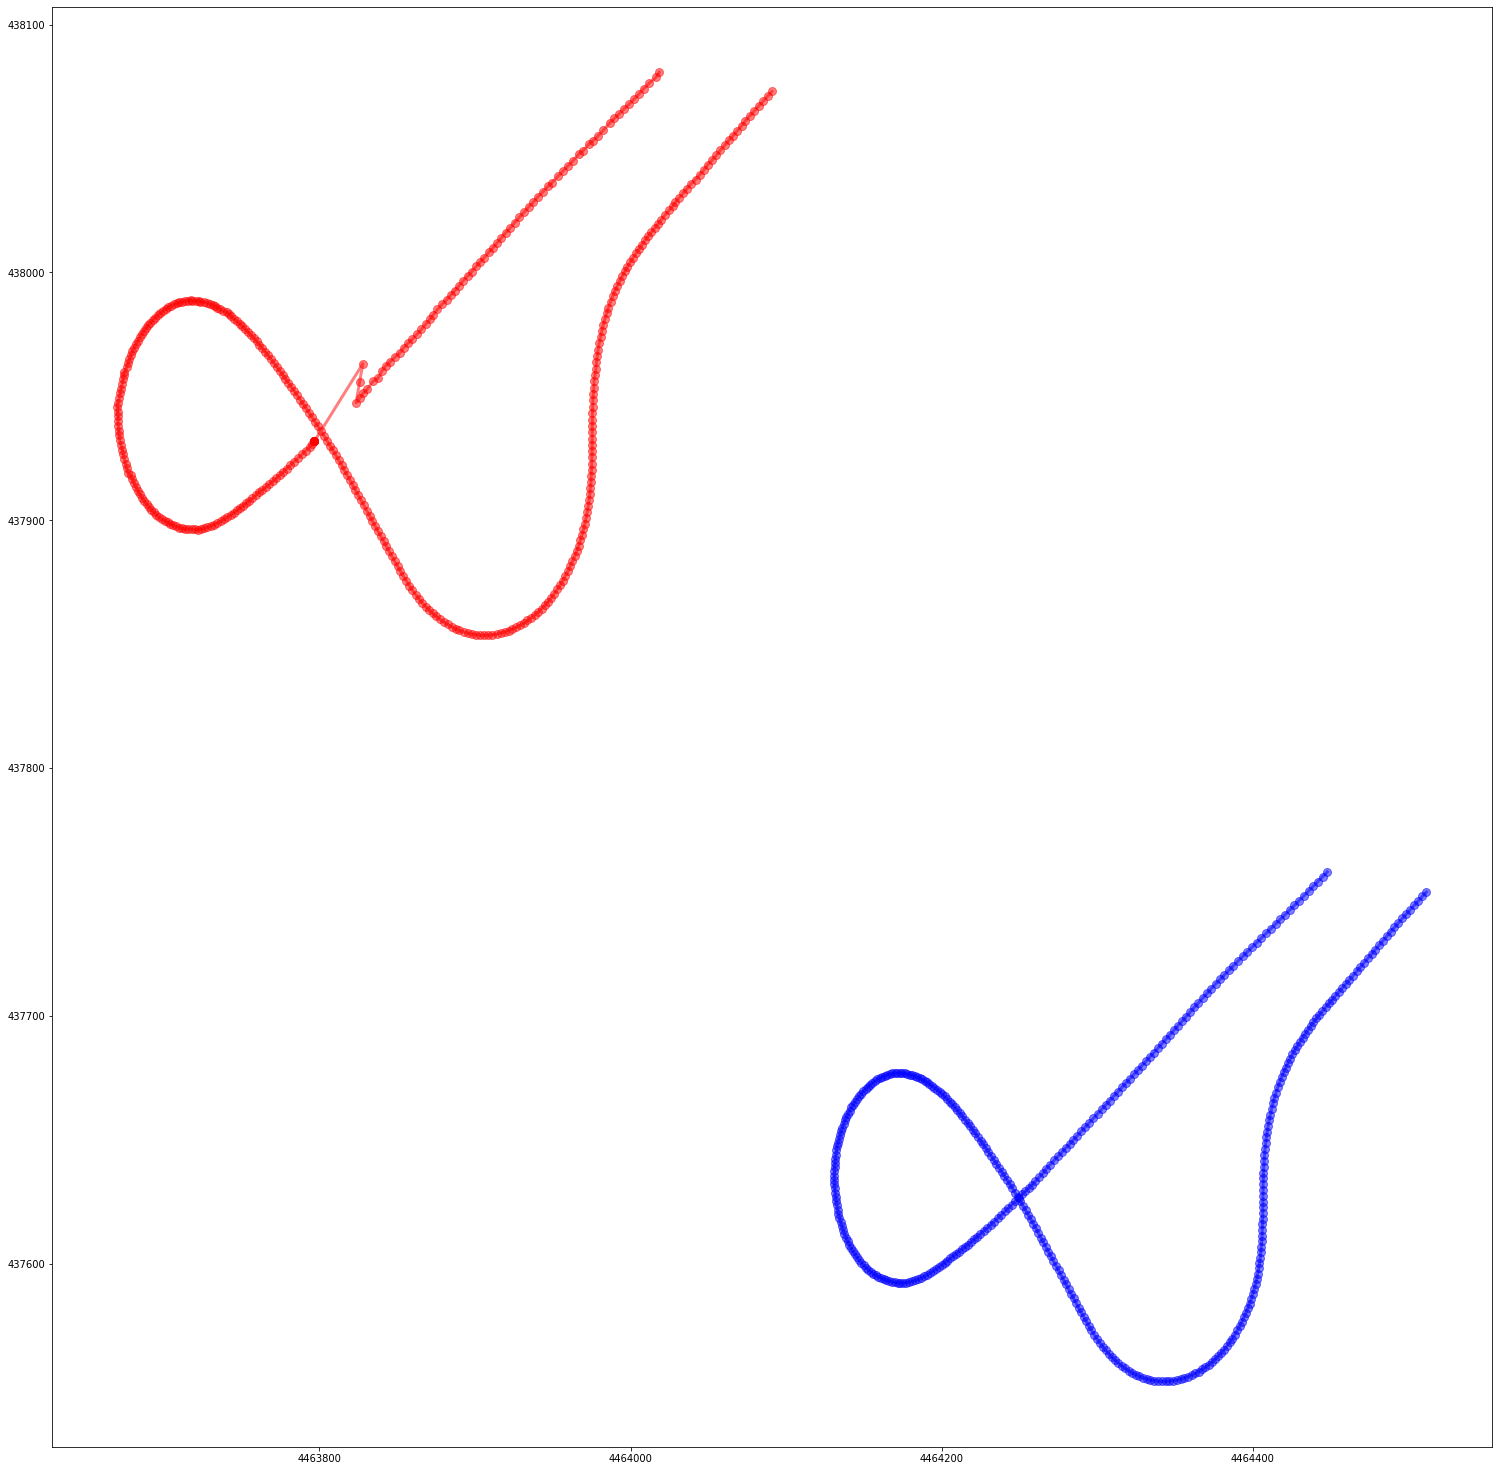

In [424]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[2850:3250]['North_Prediction(x)'],Prediction_DataFrame[2850:3250]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[2850:3250]['North'],Pos_DataFrame[2850:3250]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

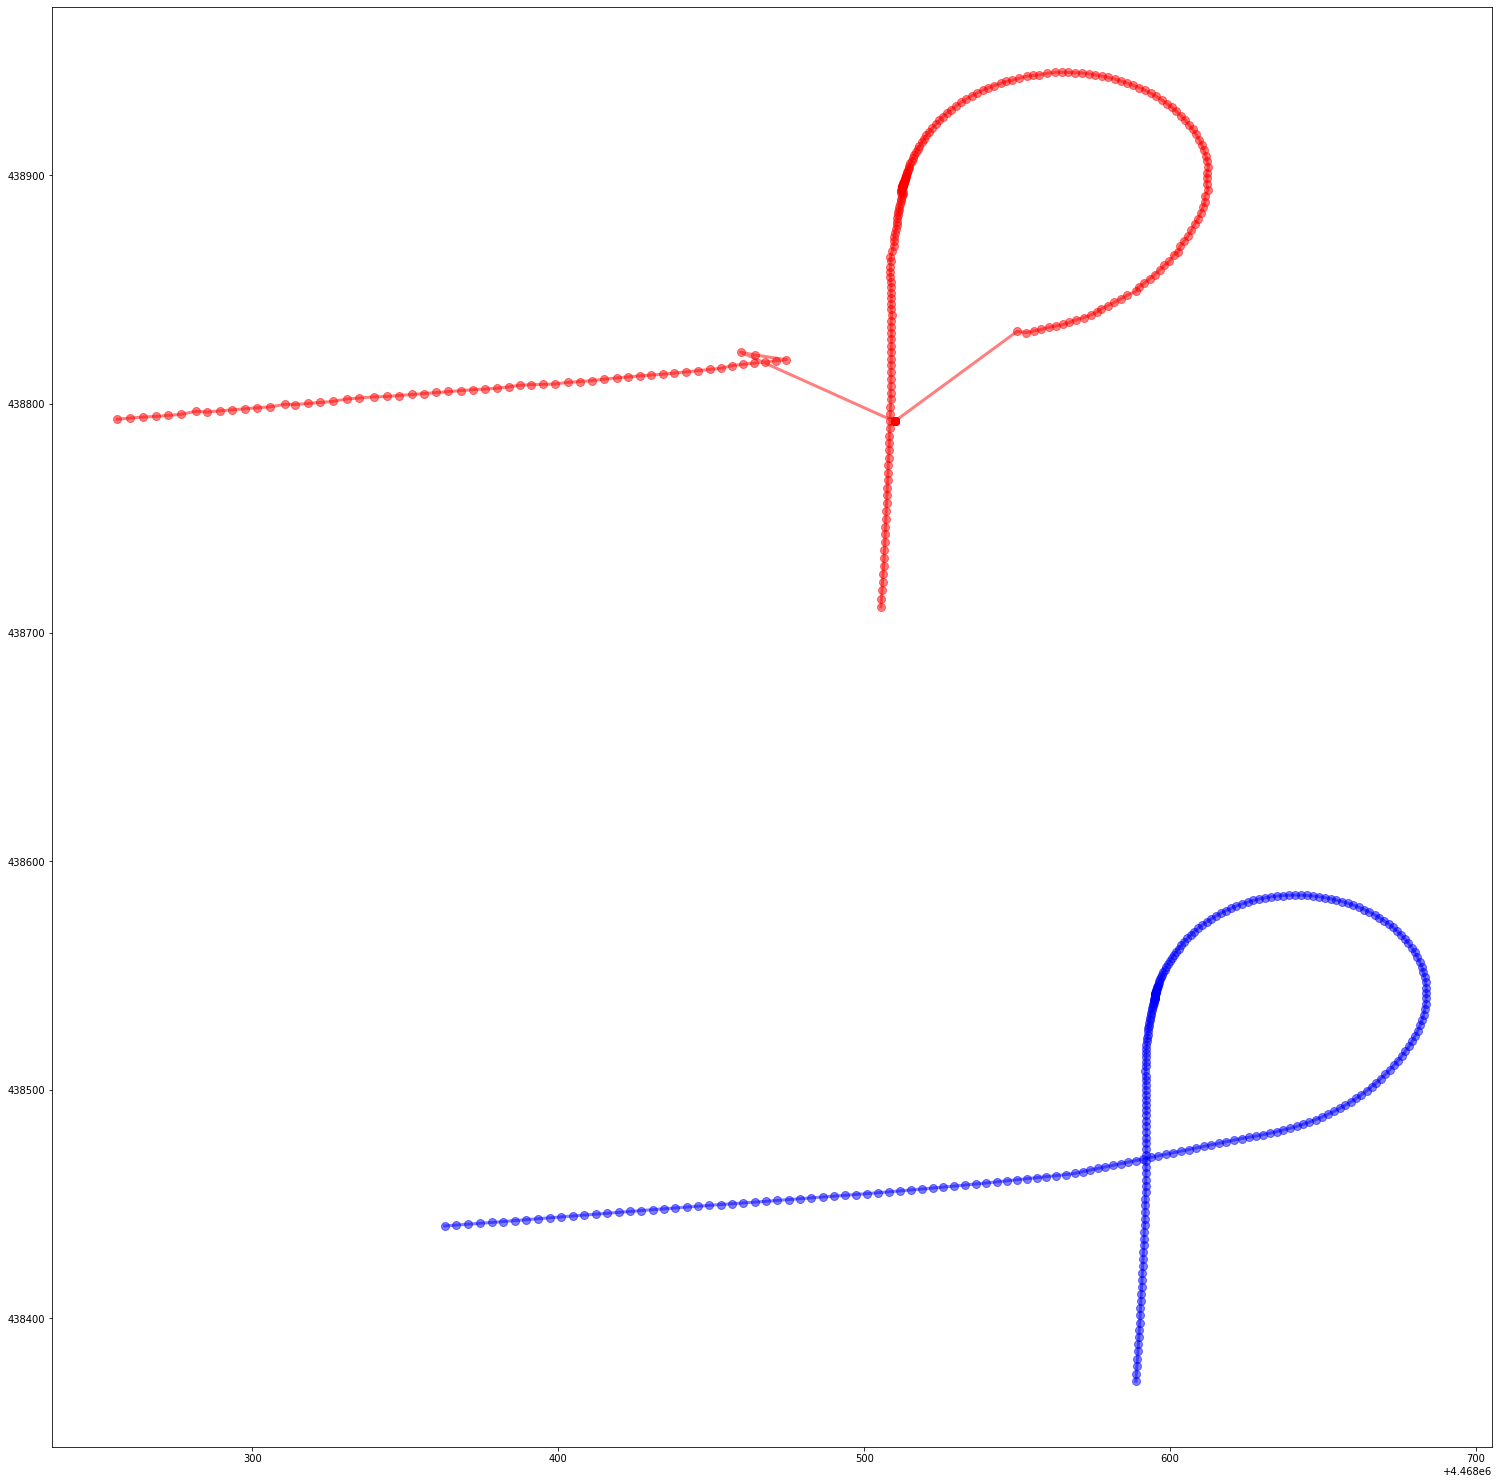

In [425]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[4300:4600]['North_Prediction(x)'],Prediction_DataFrame[4300:4600]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[4300:4600]['North'],Pos_DataFrame[4300:4600]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

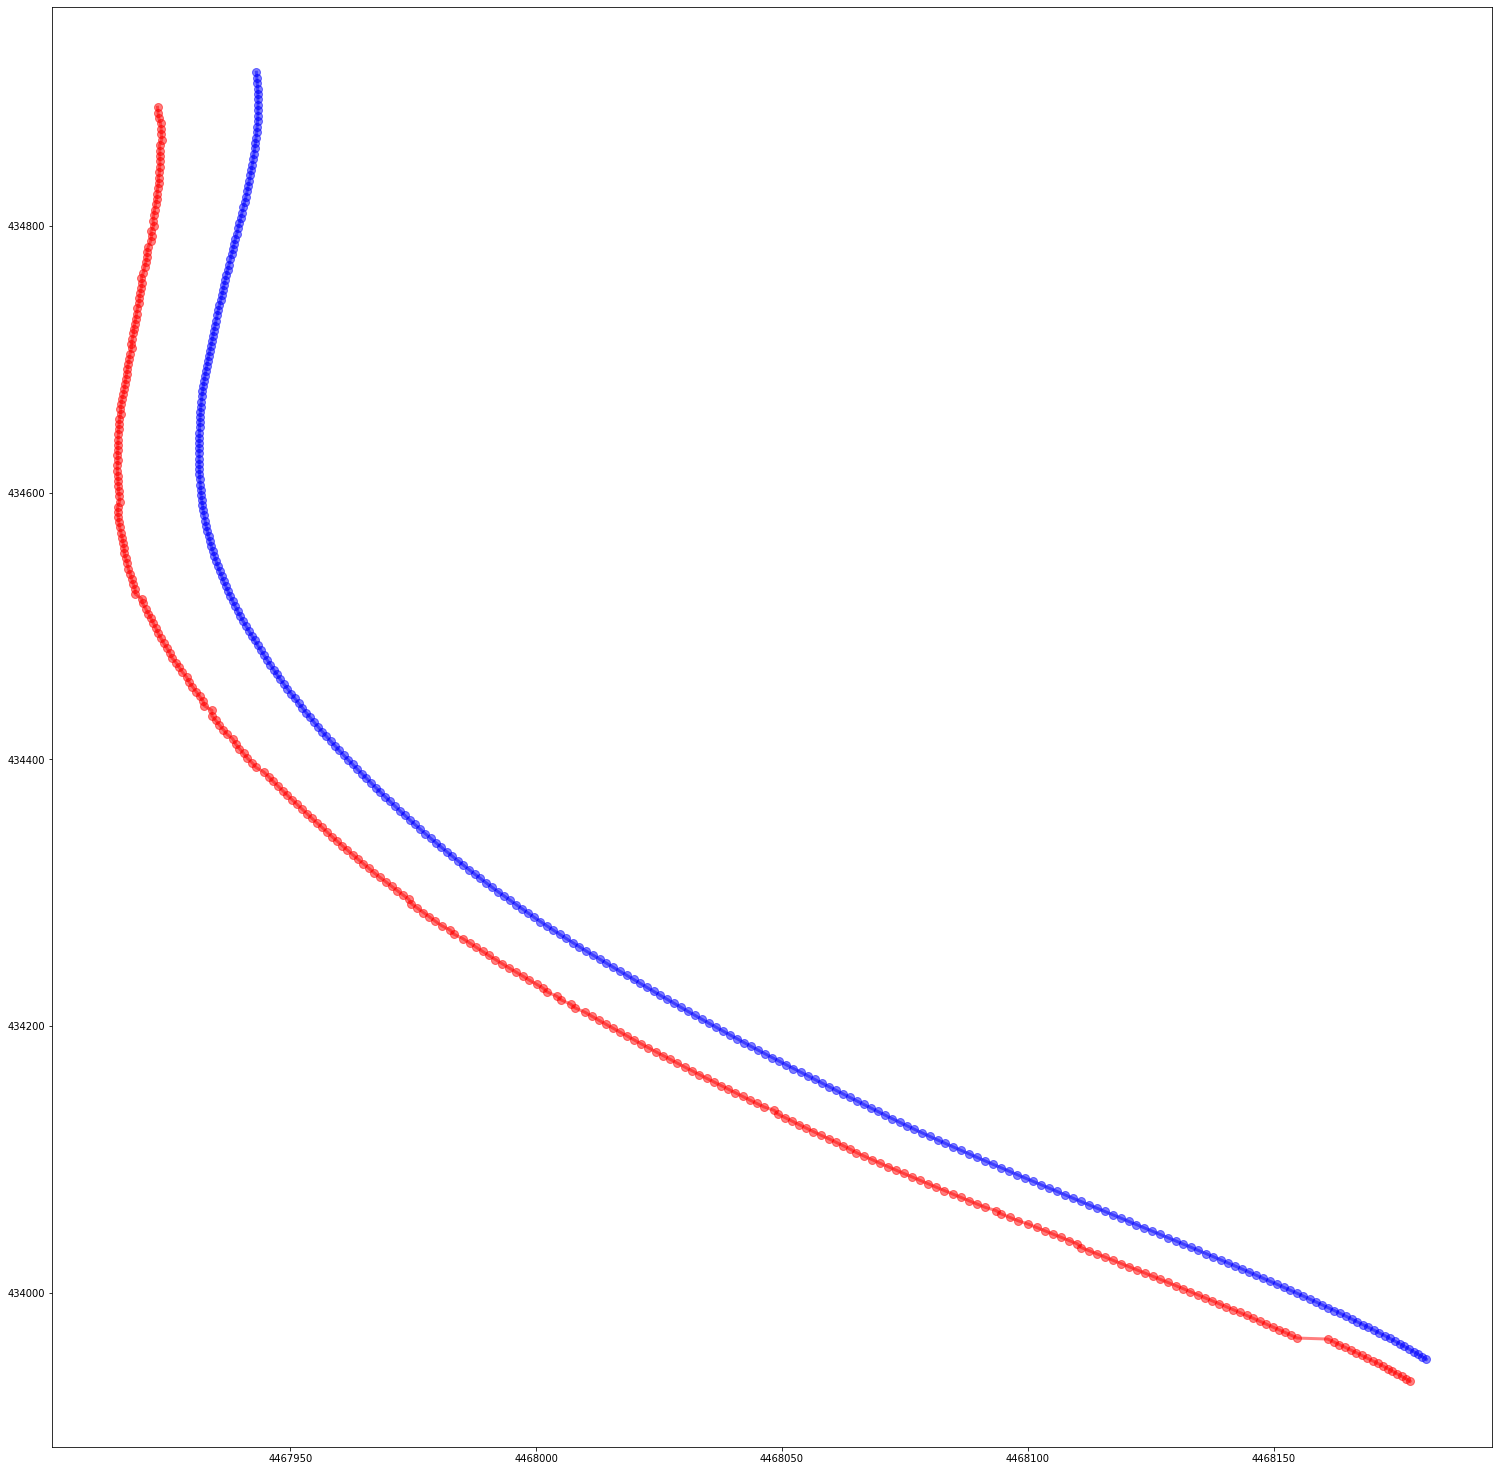

In [302]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[1000:1300]['North_Prediction(x)'],Prediction_DataFrame[1000:1300]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[1000:1300]['North'],Pos_DataFrame[1000:1300]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

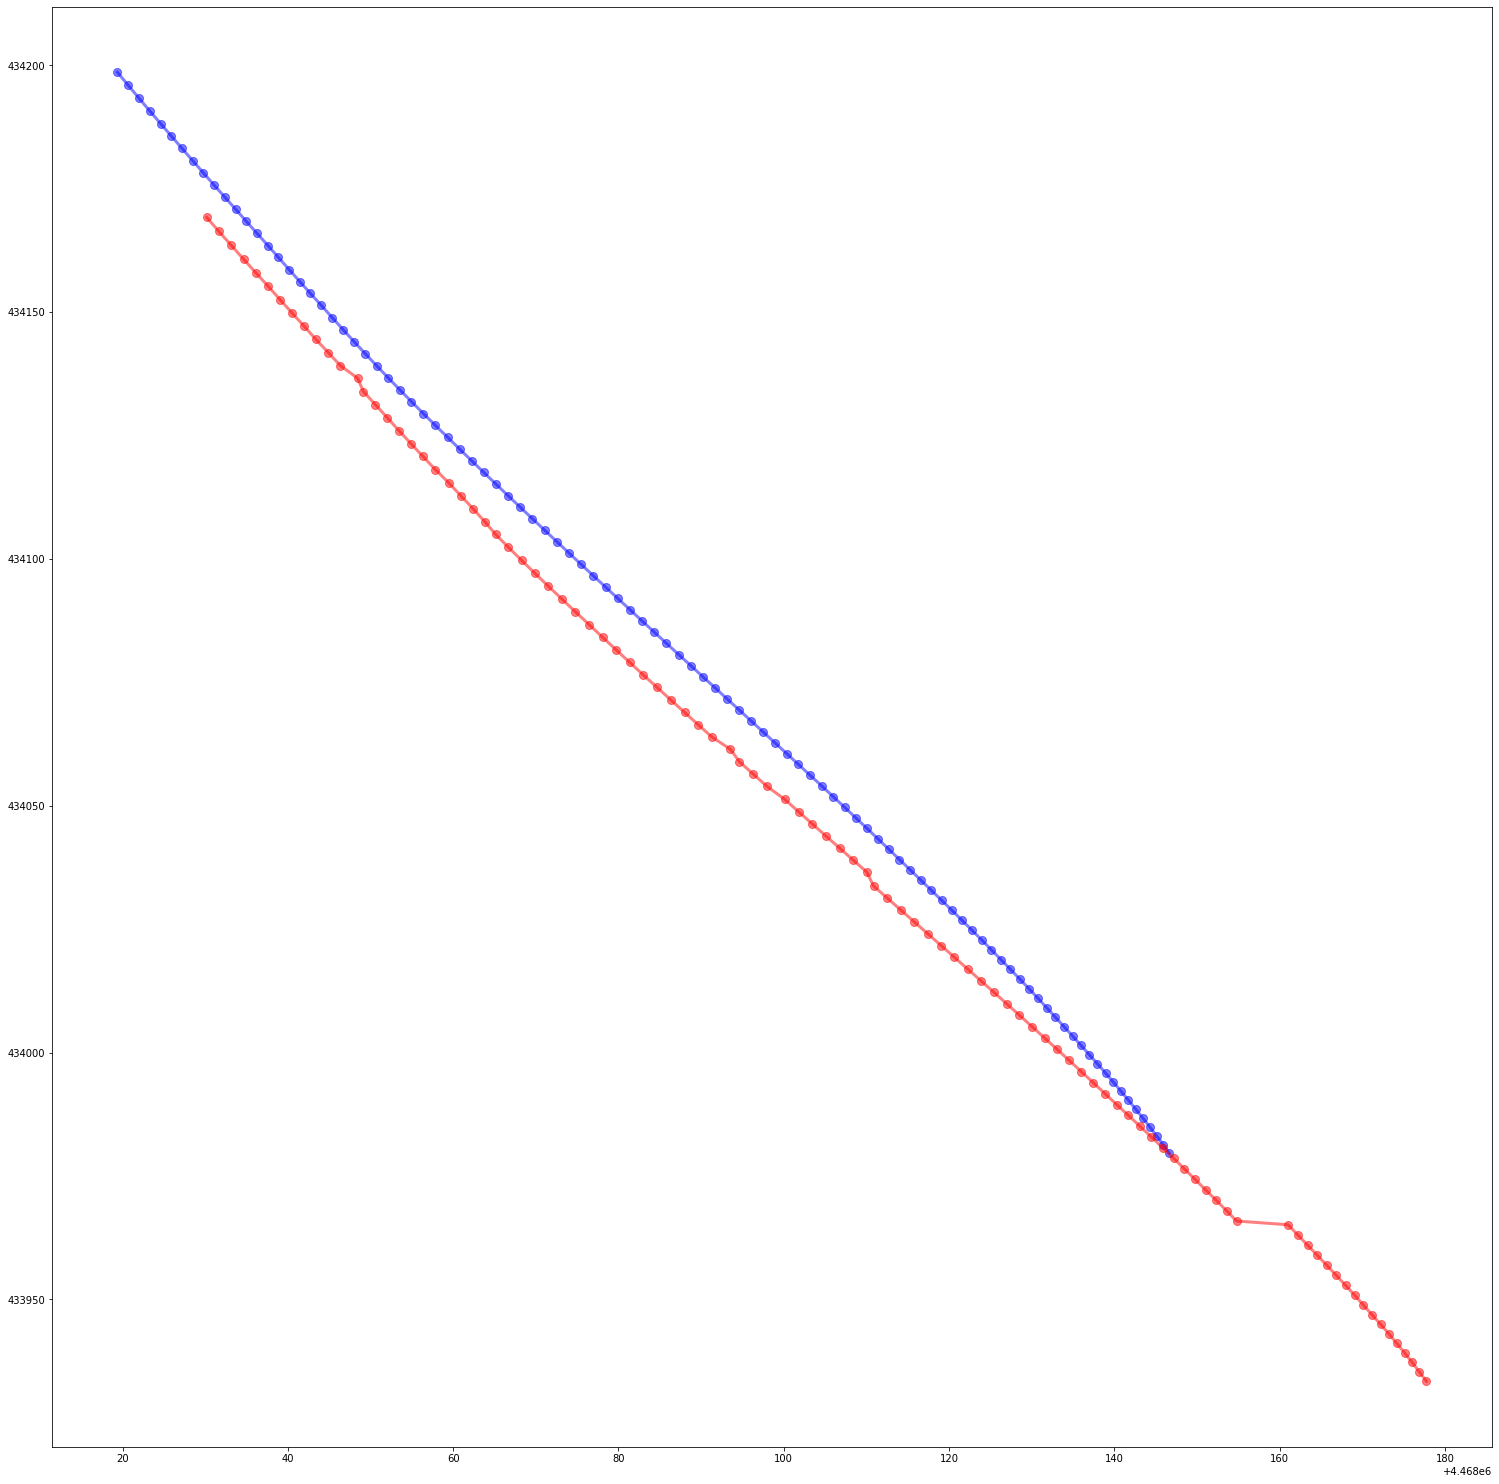

In [208]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[1000:1100]['North_Prediction(x)'],Prediction_DataFrame[1000:1100]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[1000:1100]['North'],Pos_DataFrame[1000:1100]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

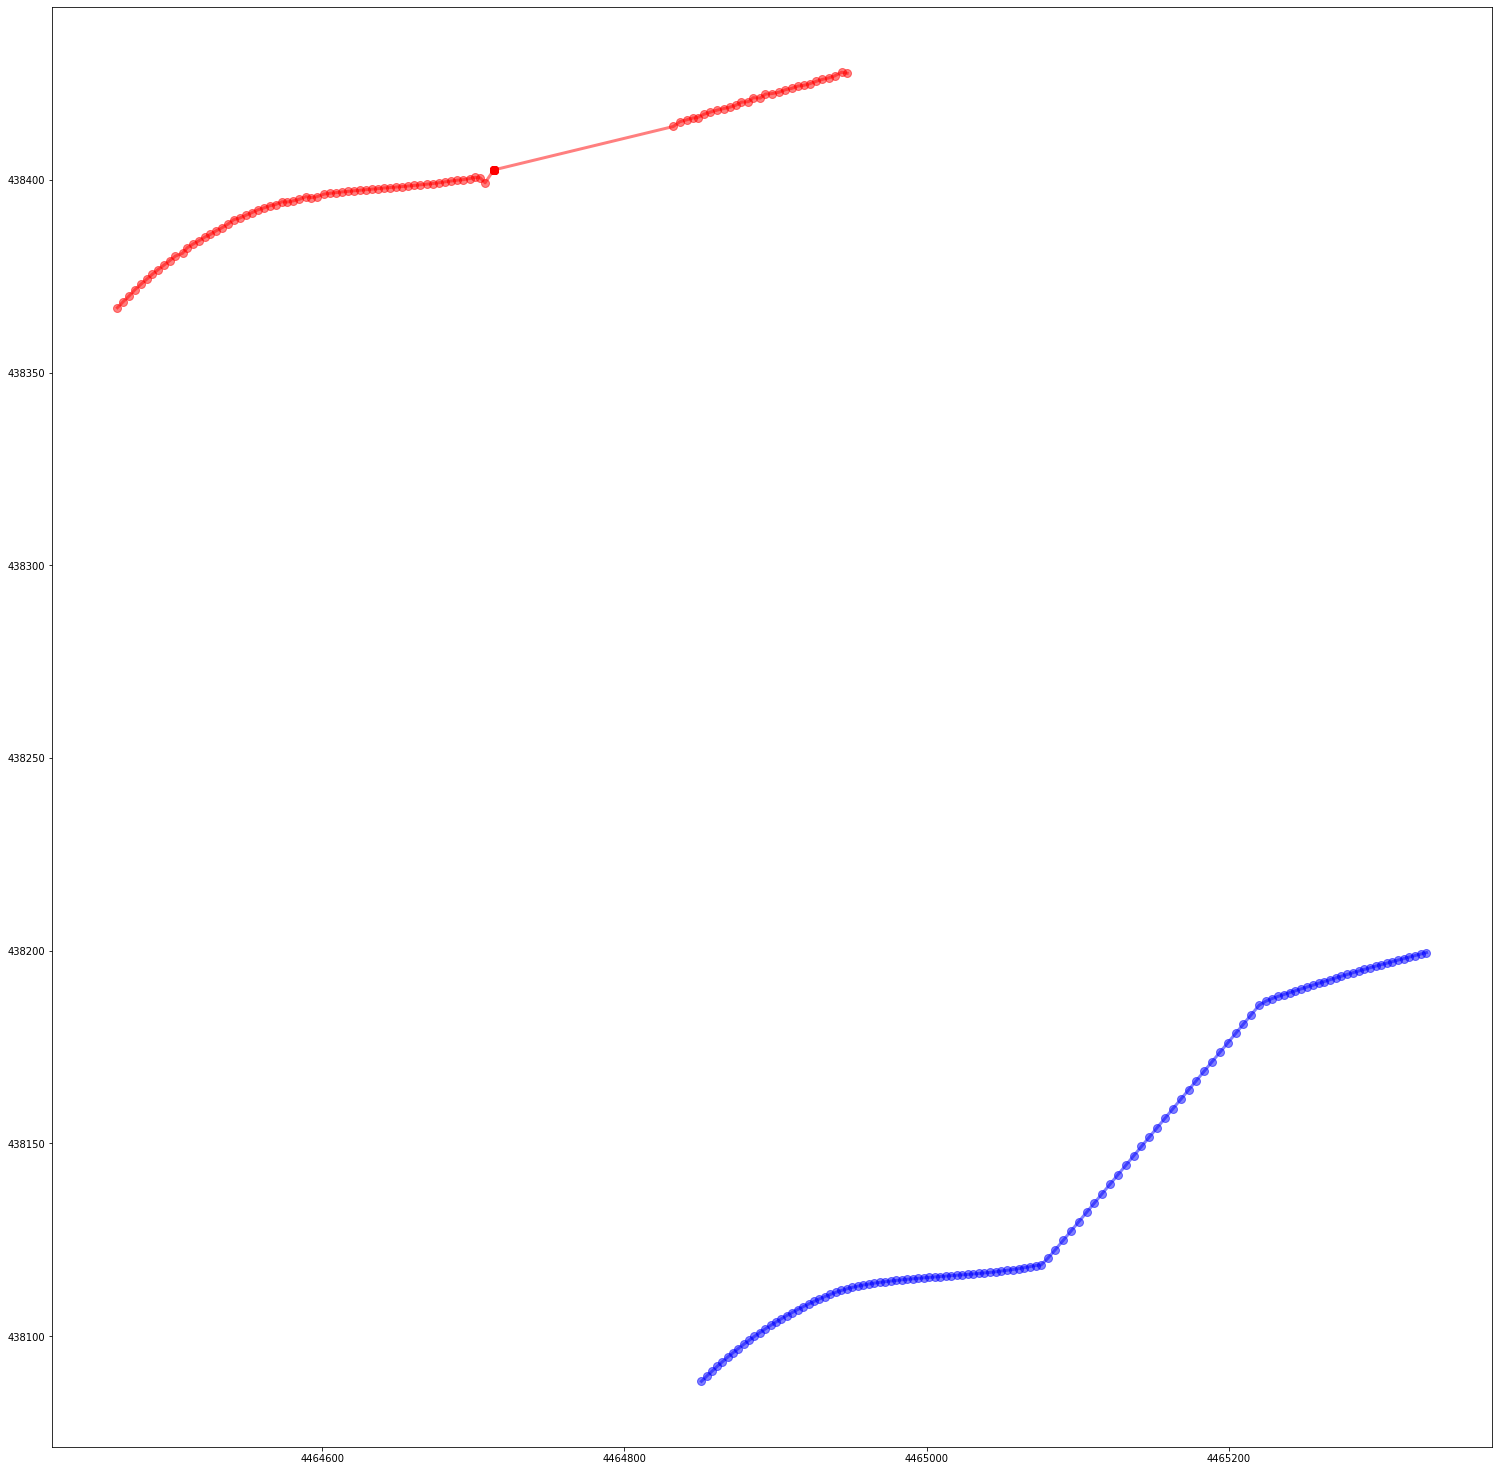

In [209]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[3380:3500]['North_Prediction(x)'],Prediction_DataFrame[3380:3500]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[3380:3500]['North'],Pos_DataFrame[3380:3500]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

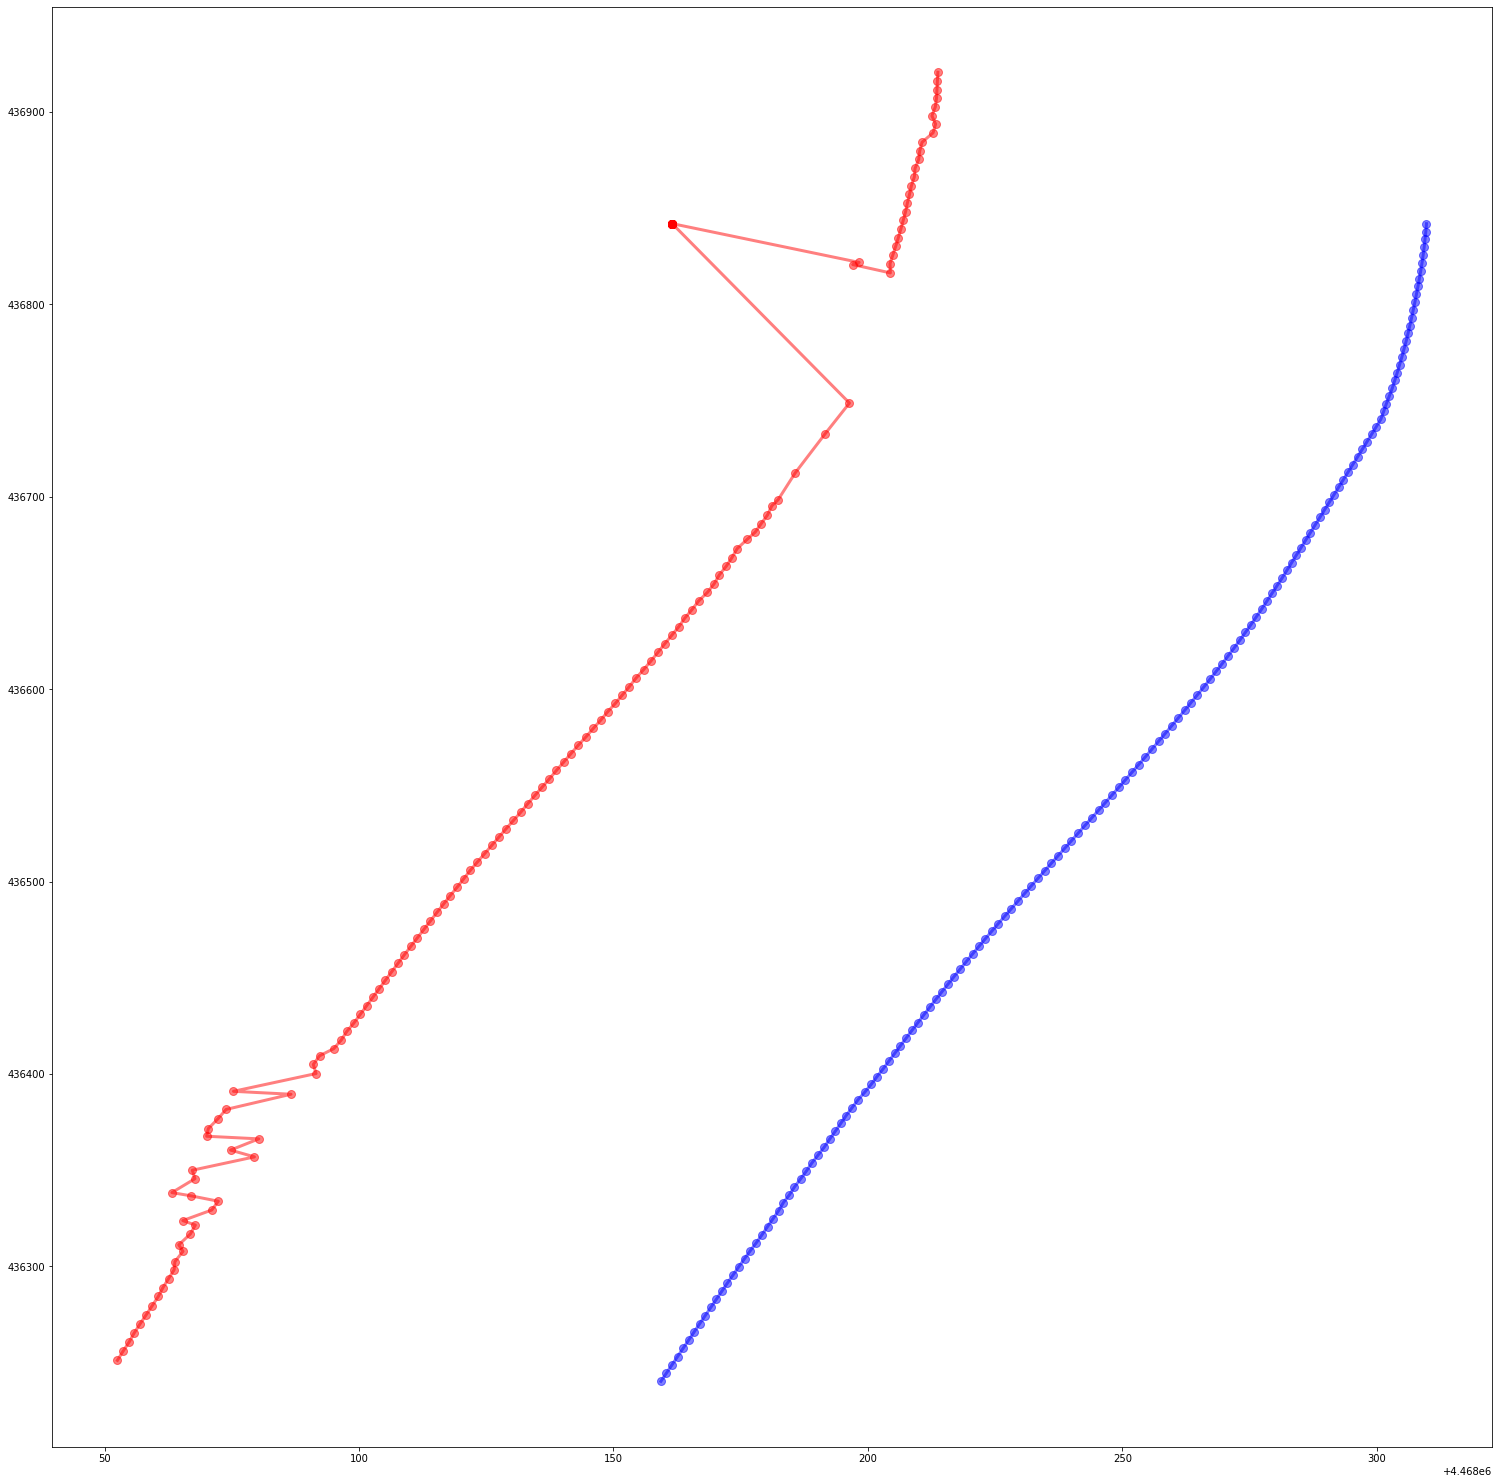

In [210]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[5020:5170]['North_Prediction(x)'],Prediction_DataFrame[5020:5170]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[5020:5170]['North'],Pos_DataFrame[5020:5170]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

In [2]:
x = np.array([[0],[0],[0],[0]])

In [3]:
x

array([[0],
       [0],
       [0],
       [0]])

In [6]:
(np.diag([Vector_err_array[0][0],Vector_err_array[0][1],0,0]))**2

array([[8.65359889, 0.        , 0.        , 0.        ],
       [0.        , 4.72671081, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [20]:
state_hat

array([[4.51246489e+06],
       [4.38598839e+05],
       [6.00000000e+00],
       [6.00000000e+00]])

In [17]:
state

array([[4.46778657e+06],
       [4.34255827e+05],
       [3.00000000e+00],
       [3.00000000e+00]])

In [4]:
dt

0.15

In [5]:
A@state

array([[4.46778702e+06],
       [4.34256277e+05],
       [3.00000000e+00],
       [3.00000000e+00]])

In [6]:
state

array([[4.46778657e+06],
       [4.34255827e+05],
       [3.00000000e+00],
       [3.00000000e+00]])

In [7]:
B@state

array([[4.46778687e+04],
       [4.34256127e+03],
       [3.00000000e+00],
       [3.00000000e+00]])

In [9]:
np.array([[Vector_array[0][0]],[Vector_array[0][1]],[0],[0]])

array([[4467786.5677],
       [ 434255.8274],
       [      0.    ],
       [      0.    ]])

In [30]:
K

array([[0.0572949 , 0.        ],
       [0.        , 0.0572949 ],
       [0.61803399, 0.        ],
       [0.        , 0.61803399]])

In [31]:
H

array([[0, 0, 1, 0],
       [0, 0, 0, 1]])

In [32]:
S

array([[261.80339887,   0.        ],
       [  0.        , 261.80339887]])

In [33]:
P

array([[7.63709404e+05, 0.00000000e+00, 5.72949017e+00, 0.00000000e+00],
       [0.00000000e+00, 7.63705477e+05, 0.00000000e+00, 5.72949017e+00],
       [5.72949017e+00, 0.00000000e+00, 6.18033989e+01, 0.00000000e+00],
       [0.00000000e+00, 5.72949017e+00, 0.00000000e+00, 6.18033989e+01]])

In [8]:
Z

array([[ 3.62693376],
       [-3.78580286]])

In [9]:
H@state

array([[-0.1096584 ],
       [-0.15028496]])

In [10]:
Z-H@state

array([[ 3.73659216],
       [-3.63551791]])

In [11]:
K@(Z-H@state)

array([[0.00450598],
       [0.00450598],
       [0.04099458],
       [0.04099458]])

In [12]:
state

array([[ 4.46709100e+06],
       [ 4.33514742e+05],
       [-1.09658400e-01],
       [-1.50284957e-01]])

In [39]:
Vel_array[0][0]

0.15

In [4]:
(np.diag([Vector_err_array[0][0],Vector_err_array[0][1],0,0]))**2 

array([[8.65359889, 0.        , 0.        , 0.        ],
       [0.        , 4.72671081, 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [5]:
Vector

,North,East,Total_Speed
0,4.467787e+06,434255.8274,0.0336
1,4.467787e+06,434255.8075,0.0266
2,4.467787e+06,434255.8008,0.0289
3,4.467787e+06,434255.8083,0.0509
4,4.467787e+06,434255.7969,0.0189
...,...,...,...
7464,4.465371e+06,434616.0183,5.2434
7465,4.465370e+06,434616.5709,5.1325
7466,4.465369e+06,434617.1803,5.2209
7467,4.465368e+06,434617.7713,5.2180


In [45]:
Vector_errors.min()

N_dev      0.8366
E_dev      0.6536
Vel_dev    0.0000
dtype: float64

In [52]:
Vector_errors[Vector_errors['N_dev']<0.843]

,N_dev,E_dev,Vel_dev
1048,0.8422,0.6823,0
1214,0.8429,0.6598,0
1215,0.8426,0.6589,0
1218,0.8395,0.6573,0
1219,0.8374,0.6567,0
1220,0.8373,0.6563,0
1221,0.8369,0.6557,0
1222,0.8366,0.6554,0


In [7]:
state

array([[ 4.46618701e+06],
       [ 4.34601832e+05],
       [-1.03261158e+00],
       [ 8.38343629e-01]])

In [12]:
Vel_DataFrame

,Latency,Hspeed,TrackDir,Vspeed,Total_Speed
0,0.15,0.0336,166.242521,-0.0081,0.0336
1,0.15,0.0266,301.963850,-0.0172,0.0266
2,0.15,0.0289,162.903724,0.0165,0.0289
3,0.15,0.0509,353.763645,-0.0428,0.0509
4,0.15,0.0189,137.506106,-0.0046,0.0189
...,...,...,...,...,...
7464,0.15,5.2434,148.425025,0.1254,5.2434
7465,0.15,5.1325,145.897548,-0.0682,5.1325
7466,0.15,5.2209,143.519298,0.0266,5.2209
7467,0.15,5.2180,139.545328,-0.0547,5.2180


In [16]:
Vel_array[7465][0]

0.15

In [36]:
P

array([[ 1.68753192e+03,  6.00311990e-01,  1.45194759e+00,
        -4.60467955e-02],
       [ 6.00311990e-01,  1.68360503e+03, -4.60467955e-02,
         1.45194759e+00],
       [ 1.45194759e+00, -4.60467955e-02,  6.27996584e-01,
         6.26659506e-01],
       [-4.60467955e-02,  1.45194759e+00,  6.26659506e-01,
         6.27996584e-01]])

In [37]:
Q

array([[0.00050625, 0.00050625, 0.00675   , 0.00675   ],
       [0.00050625, 0.00050625, 0.00675   , 0.00675   ],
       [0.00675   , 0.00675   , 0.09      , 0.09      ],
       [0.00675   , 0.00675   , 0.09      , 0.09      ]])

In [82]:
Vel_DataFrame

,Latency,Hspeed,TrackDir,Vspeed,Total_Speed
0,0.15,0.0336,166.242521,-0.0081,0.0336
1,0.15,0.0266,301.963850,-0.0172,0.0266
2,0.15,0.0289,162.903724,0.0165,0.0289
3,0.15,0.0509,353.763645,-0.0428,0.0509
4,0.15,0.0189,137.506106,-0.0046,0.0189
...,...,...,...,...,...
7464,0.15,5.2434,148.425025,0.1254,5.2434
7465,0.15,5.1325,145.897548,-0.0682,5.1325
7466,0.15,5.2209,143.519298,0.0266,5.2209
7467,0.15,5.2180,139.545328,-0.0547,5.2180


In [98]:
Vel_array.mean(axis=0)[0]

0.18236042308208952

In [95]:
Vel_array.mean(axis=0)

array([1.82360423e-01, 1.51633947e+01, 1.59823356e+02, 7.58923015e-02])

In [201]:
Pos_array.mean(axis=0)

array([4.46695040e+06, 4.36149969e+05, 6.42170033e+02, 3.45329118e+00,
       2.90612271e+00, 5.77242755e+00])

In [199]:
Pos_DataFrame

,North,East,Height,N_dev,E_dev,Hei_dev
0,4.467787e+06,434255.8274,666.3304,2.9417,2.1741,5.1275
1,4.467787e+06,434255.8075,666.3376,2.9461,2.1774,5.1355
2,4.467787e+06,434255.8008,666.3382,2.9507,2.1809,5.1437
3,4.467787e+06,434255.8083,666.3249,2.9556,2.1845,5.1520
4,4.467787e+06,434255.7969,666.3262,2.9600,2.1875,5.1602
...,...,...,...,...,...,...
7464,4.465371e+06,434616.0183,658.3640,1.5535,1.2439,3.0956
7465,4.465370e+06,434616.5709,658.3988,1.5530,1.2437,3.0945
7466,4.465369e+06,434617.1803,658.4048,1.5490,1.2396,3.0783
7467,4.465368e+06,434617.7713,658.4657,1.5487,1.2395,3.0776


In [200]:
Vel_DataFrame

,Latency,Hspeed,TrackDir,Vspeed,Total_Speed
0,0.15,0.0336,166.242521,-0.0081,0.0336
1,0.15,0.0266,301.963850,-0.0172,0.0266
2,0.15,0.0289,162.903724,0.0165,0.0289
3,0.15,0.0509,353.763645,-0.0428,0.0509
4,0.15,0.0189,137.506106,-0.0046,0.0189
...,...,...,...,...,...
7464,0.15,5.2434,148.425025,0.1254,5.2434
7465,0.15,5.1325,145.897548,-0.0682,5.1325
7466,0.15,5.2209,143.519298,0.0266,5.2209
7467,0.15,5.2180,139.545328,-0.0547,5.2180


In [8]:
Prediction_DataFrame.iloc[3000:3015]

,North_Prediction(x),South_Prediction(y)
3000,4.463930e+06,437711.752012
3001,4.463928e+06,437713.758089
3002,4.463927e+06,437715.761913
3003,4.463925e+06,437717.761937
3004,4.463923e+06,437719.766079
3005,4.463921e+06,437721.696880
3006,4.463919e+06,437723.667303
3007,4.463917e+06,437725.634088
3008,4.463916e+06,437727.564597
3009,4.463914e+06,437729.496659


In [2]:
Vel_DataFrame

,Latency,Hspeed,TrackDir,Vspeed,Total_Speed
0,0.15,0.0336,166.242521,-0.0081,0.0336
1,0.15,0.0266,301.963850,-0.0172,0.0266
2,0.15,0.0289,162.903724,0.0165,0.0289
3,0.15,0.0509,353.763645,-0.0428,0.0509
4,0.15,0.0189,137.506106,-0.0046,0.0189
...,...,...,...,...,...
7464,0.15,5.2434,148.425025,0.1254,5.2434
7465,0.15,5.1325,145.897548,-0.0682,5.1325
7466,0.15,5.2209,143.519298,0.0266,5.2209
7467,0.15,5.2180,139.545328,-0.0547,5.2180


In [15]:
Vector.iloc[1514:1535]

,North,East,Total_Speed
1514,4.467464e+06,435673.0712,21.0463
1515,4.467482e+06,435609.1511,18.1525
1516,4.467482e+06,435609.1511,18.1525
1517,4.467482e+06,435609.1511,18.1525
1518,4.467482e+06,435609.1511,18.1525
1519,4.467482e+06,435609.1511,18.1525
1520,4.467482e+06,435609.1511,18.1525
1521,4.467482e+06,435609.1511,18.1525
1522,4.467482e+06,435609.1511,18.1525
1523,4.467482e+06,435609.1511,18.1525


In [2]:
dt

0.18236042308208952

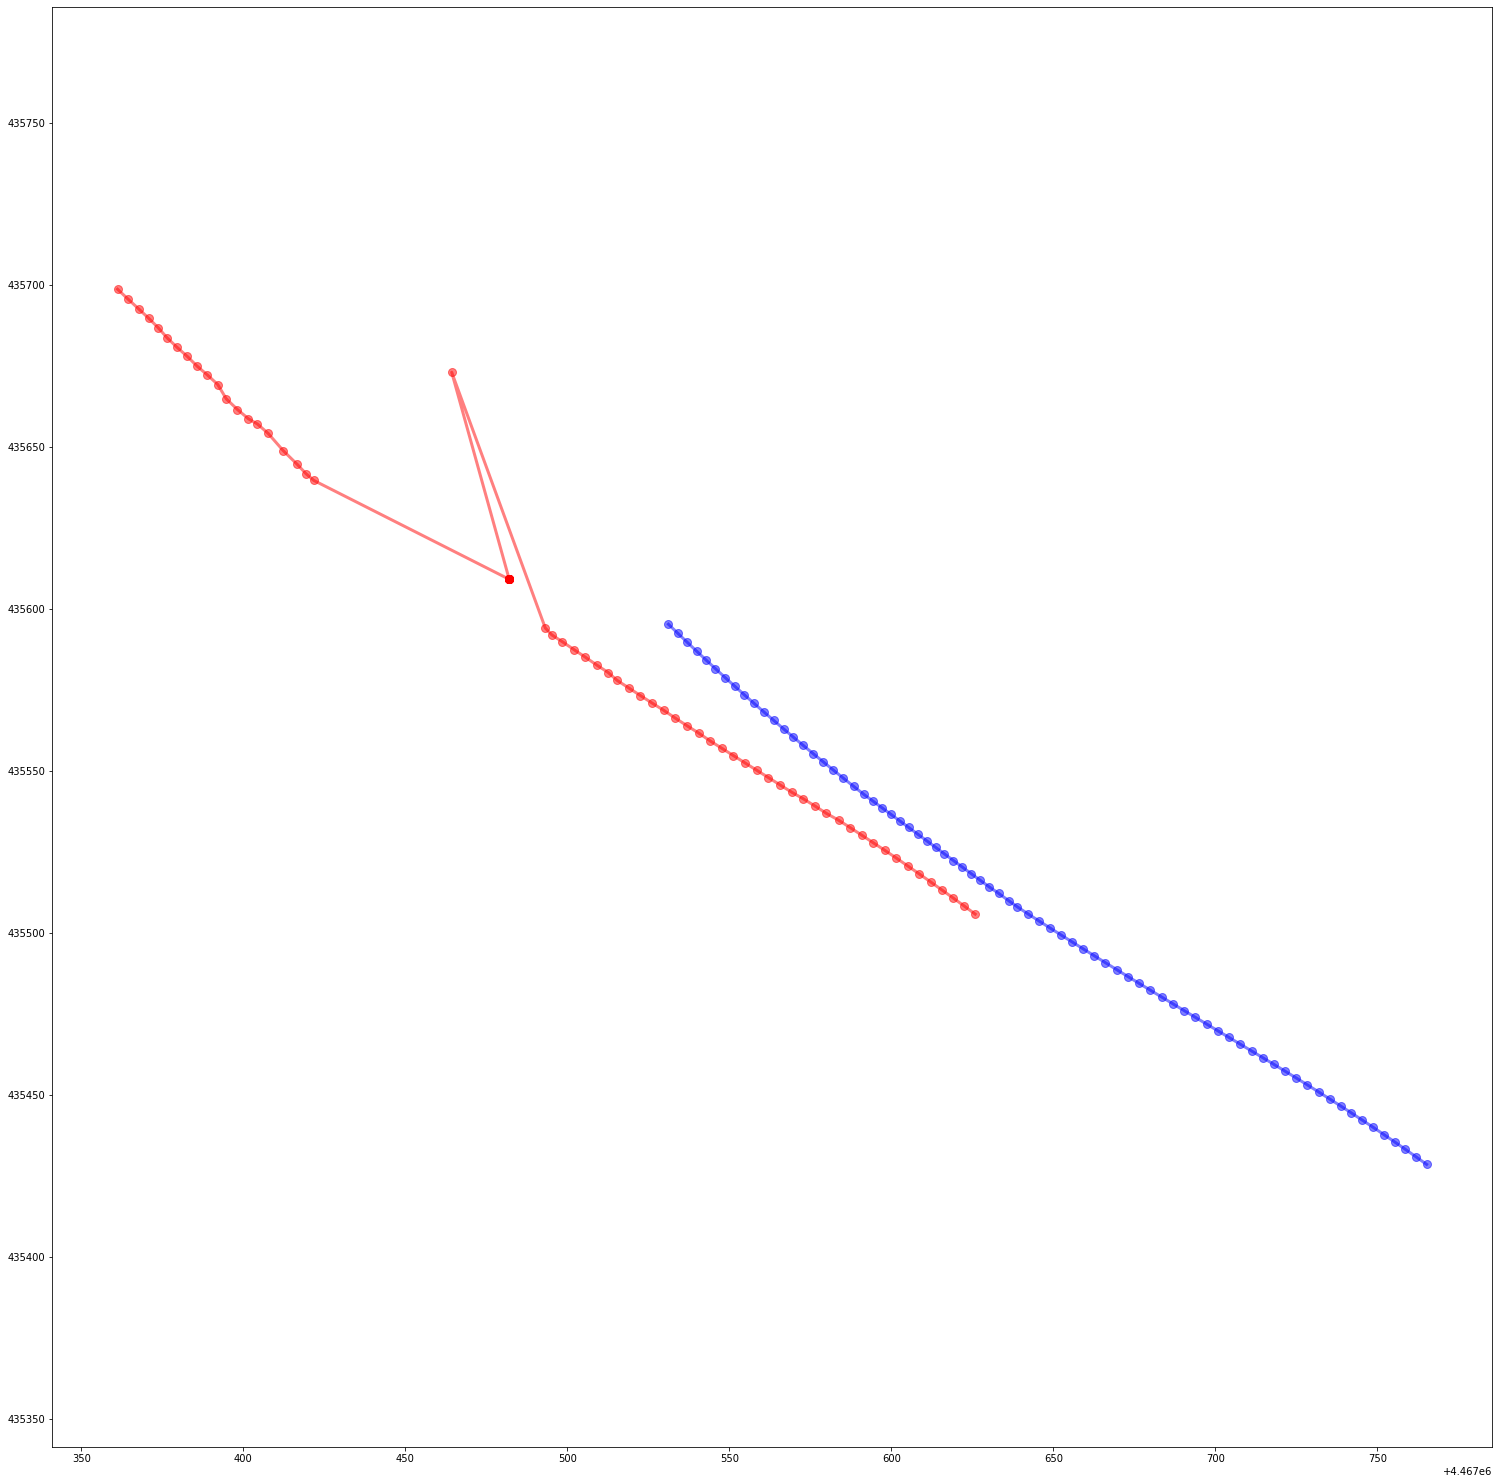

In [2]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[1475:1550]['North_Prediction(x)'],Prediction_DataFrame[1475:1550]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[1475:1550]['North'],Pos_DataFrame[1475:1550]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

In [37]:
Pos_DataFrame.iloc[1485:1535]

,North,East,Height,N_dev,E_dev,Hei_dev
1485,4.467591e+06,435530.1655,644.6105,1.1639,0.9286,1.9491
1486,4.467587e+06,435532.4874,644.3639,1.1659,0.9301,1.9523
1487,4.467584e+06,435534.7780,644.1596,1.1672,0.9315,1.9535
1488,4.467580e+06,435536.9142,643.9080,1.2795,0.9916,1.9584
1489,4.467576e+06,435539.2042,643.6896,1.2804,0.9928,1.9600
1490,4.467573e+06,435541.4386,643.4317,1.2836,0.9964,1.9661
1491,4.467569e+06,435543.4005,642.8434,1.2859,1.1214,2.0073
1492,4.467566e+06,435545.6293,642.5672,1.2893,1.1246,2.0143
1493,4.467562e+06,435547.9462,642.4886,1.2869,1.1229,2.0146
1494,4.467558e+06,435550.2030,642.2875,1.2879,1.1240,2.0148


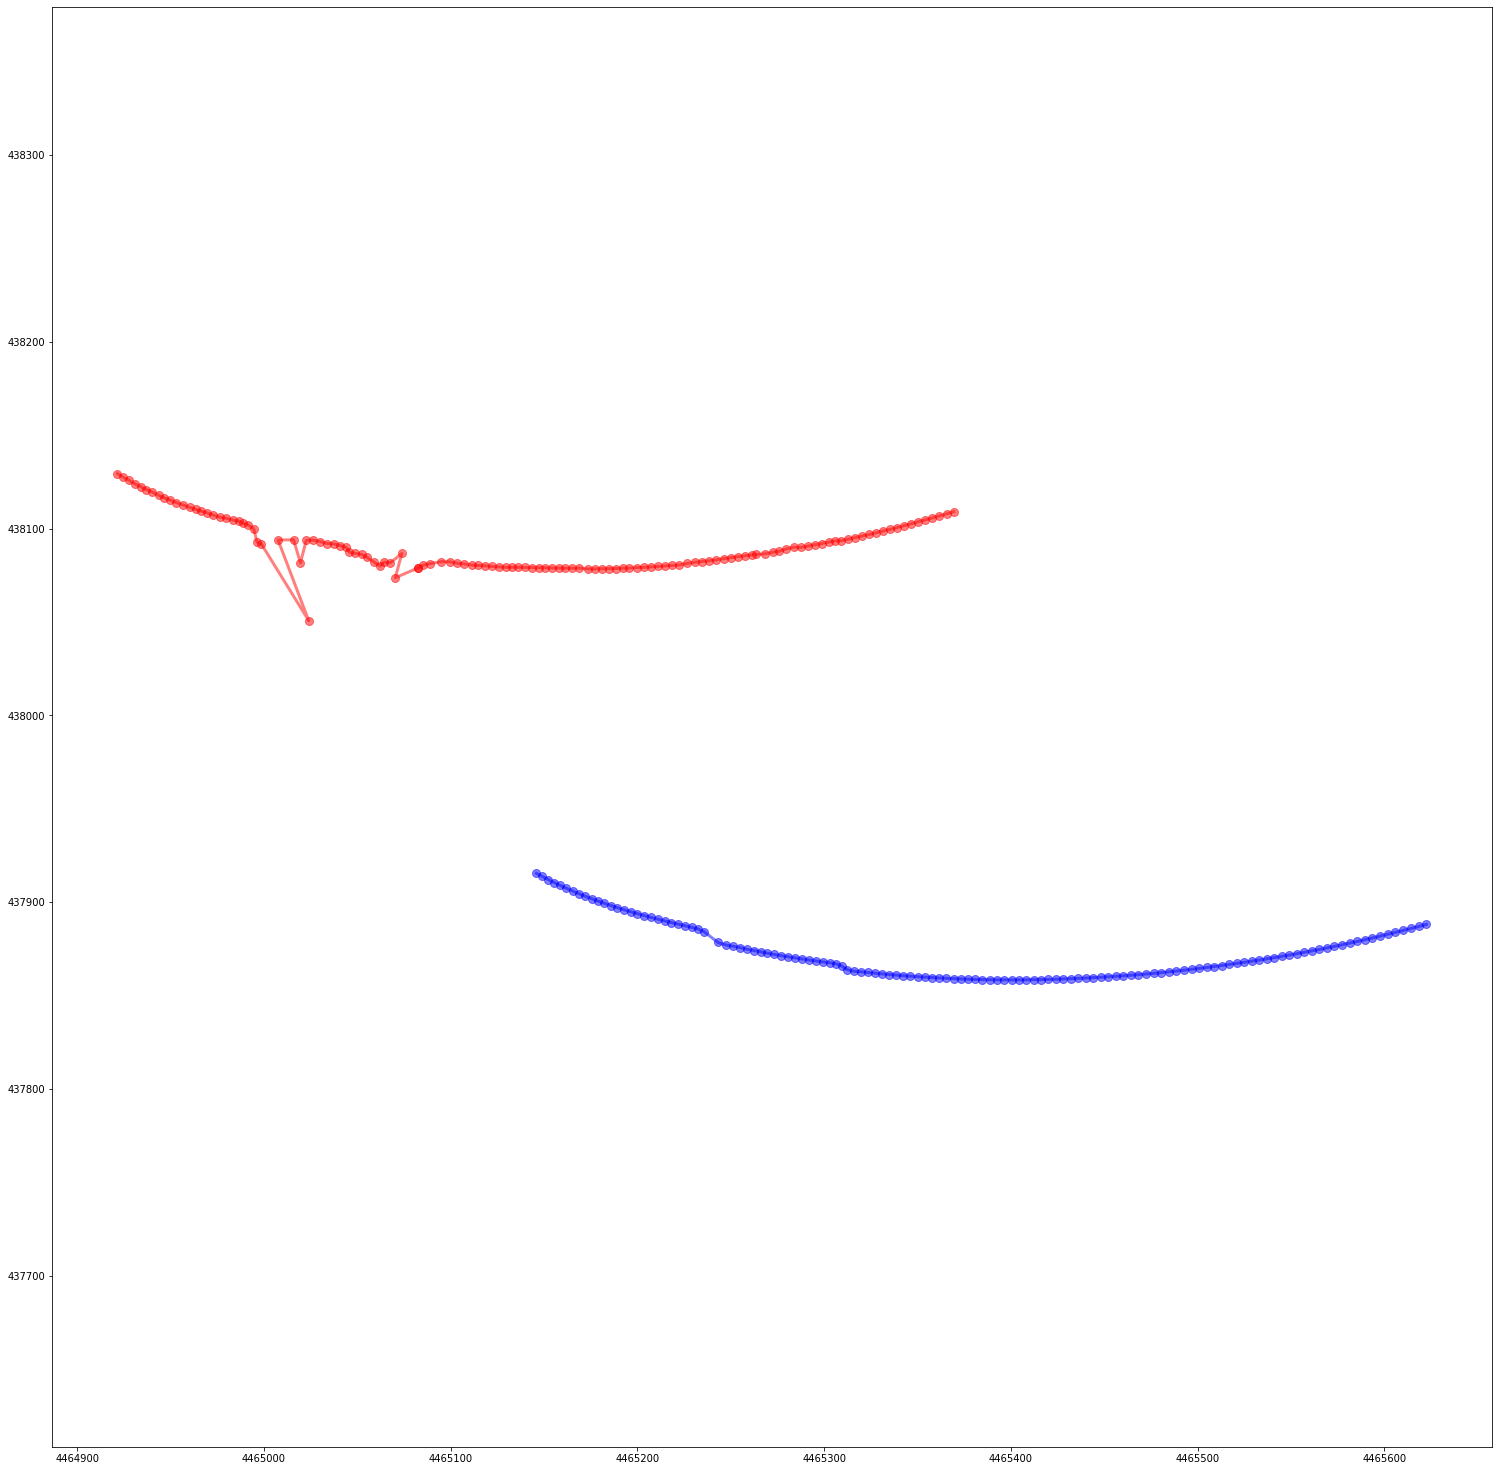

In [3]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[2420:2545]['North_Prediction(x)'],Prediction_DataFrame[2420:2545]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[2420:2545]['North'],Pos_DataFrame[2420:2545]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

In [39]:
Pos_DataFrame.iloc[2420:2545]

,North,East,Height,N_dev,E_dev,Hei_dev
2420,4.465369e+06,438109.0275,620.8791,3.0209,2.4444,5.3047
2421,4.465366e+06,438107.8990,620.9392,3.0250,2.4478,5.3118
2422,4.465362e+06,438106.7907,620.9932,3.0293,2.4513,5.3194
2423,4.465358e+06,438105.7052,621.0535,3.0334,2.4547,5.3267
2424,4.465354e+06,438104.6355,621.0874,3.0375,2.4581,5.3338
...,...,...,...,...,...,...
2540,4.464934e+06,438122.4818,616.2830,4.0650,3.3824,6.9763
2541,4.464931e+06,438124.1138,616.2570,4.0688,3.3860,6.9827
2542,4.464928e+06,438125.8976,615.9953,4.0715,3.3895,6.9870
2543,4.464925e+06,438127.6186,616.1950,4.0757,3.3929,6.9946


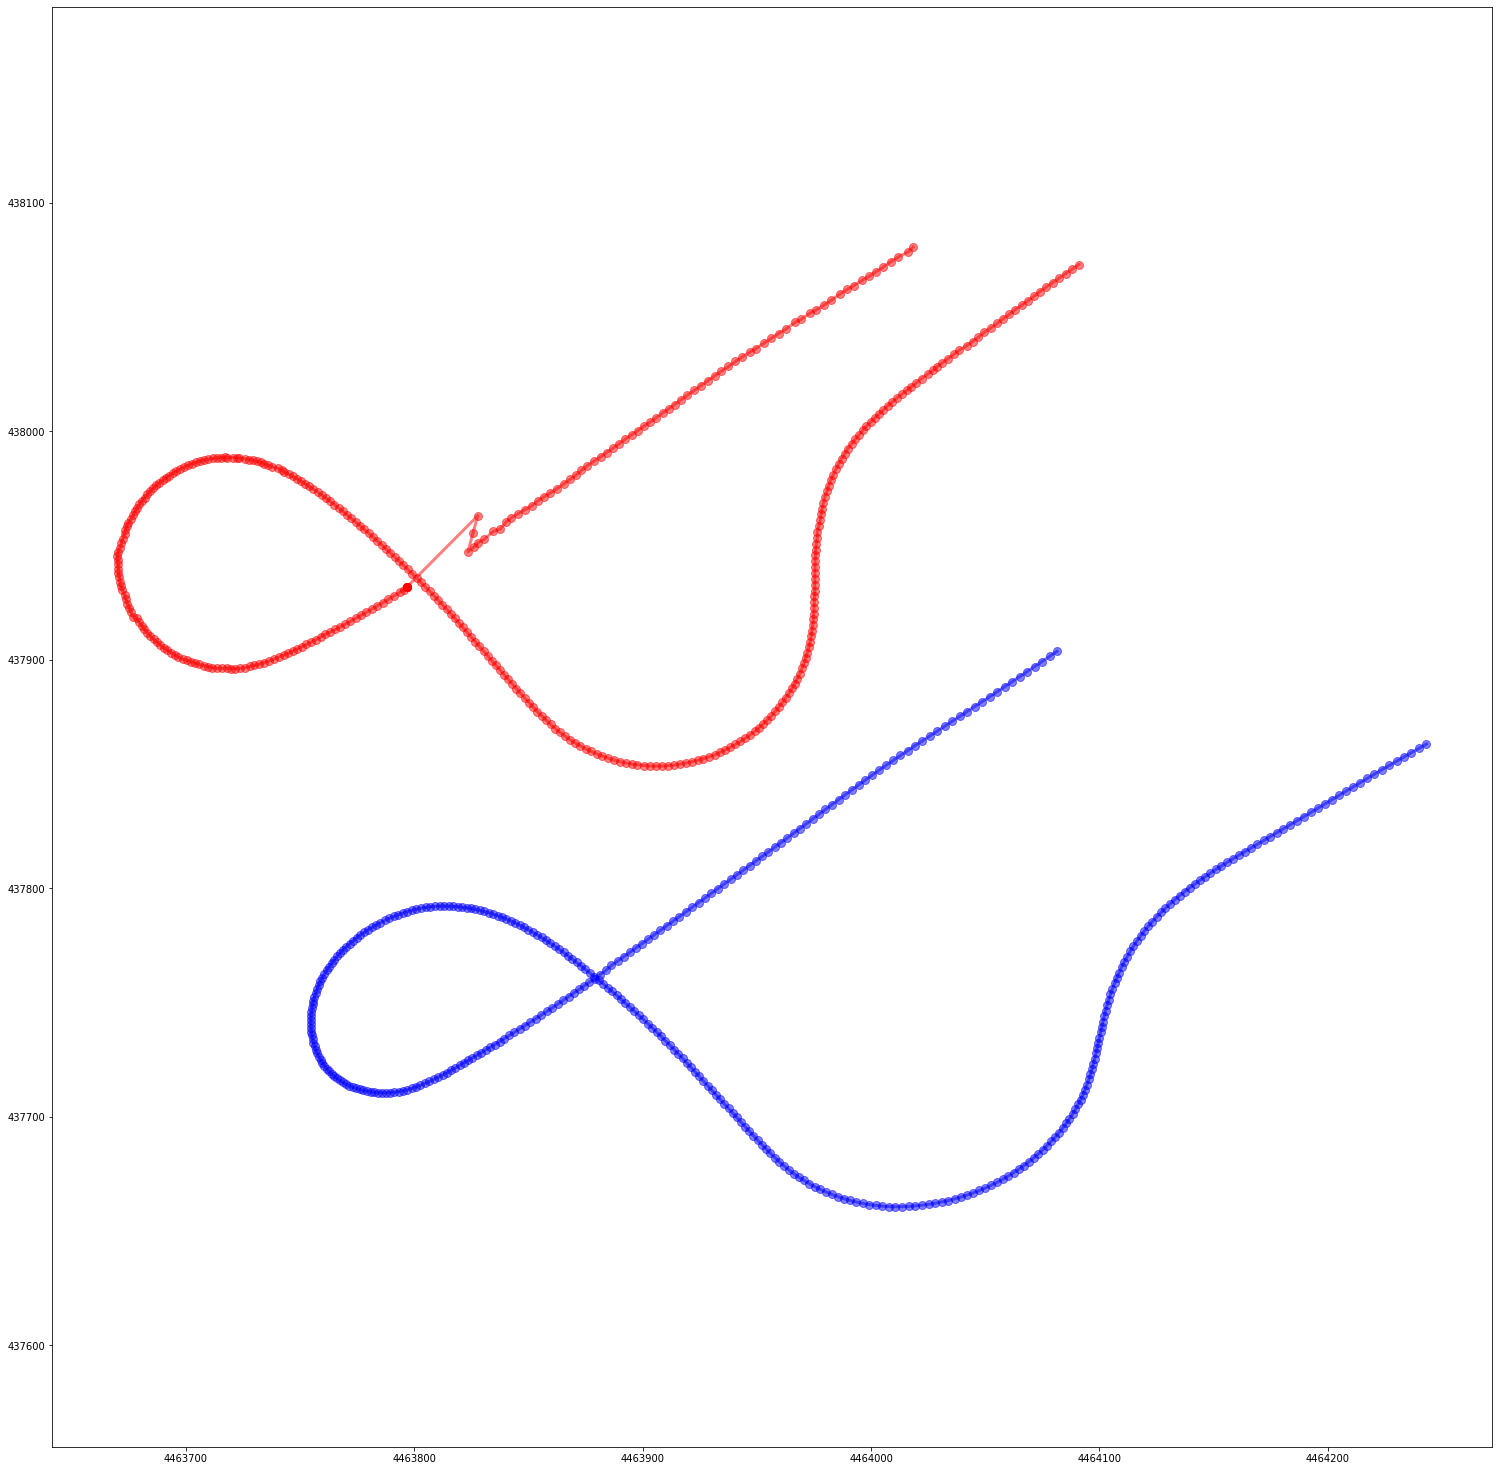

In [4]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[2850:3250]['North_Prediction(x)'],Prediction_DataFrame[2850:3250]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[2850:3250]['North'],Pos_DataFrame[2850:3250]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

In [15]:
Pos_DataFrame.iloc[2950:3000]

,North,East,Height,N_dev,E_dev,Hei_dev
2950,4.463941e+06,437863.0051,631.8305,1.0558,0.7725,1.7163
2951,4.463938e+06,437861.7594,631.9501,0.9463,0.7353,1.5069
2952,4.463936e+06,437860.6189,632.0793,0.9472,0.7361,1.5086
2953,4.463934e+06,437859.5545,632.1699,0.9512,0.7380,1.5164
2954,4.463932e+06,437858.4524,631.8682,0.9482,0.7375,1.5103
2955,4.463929e+06,437857.6351,632.2328,0.9459,0.7373,1.5063
2956,4.463927e+06,437856.8079,632.2705,0.9450,0.7377,1.5044
2957,4.463924e+06,437856.1083,632.3491,0.9437,0.7380,1.5018
2958,4.463922e+06,437855.4433,632.3040,0.9447,0.7389,1.5038
2959,4.463919e+06,437854.8974,632.3747,0.9468,0.7401,1.5075


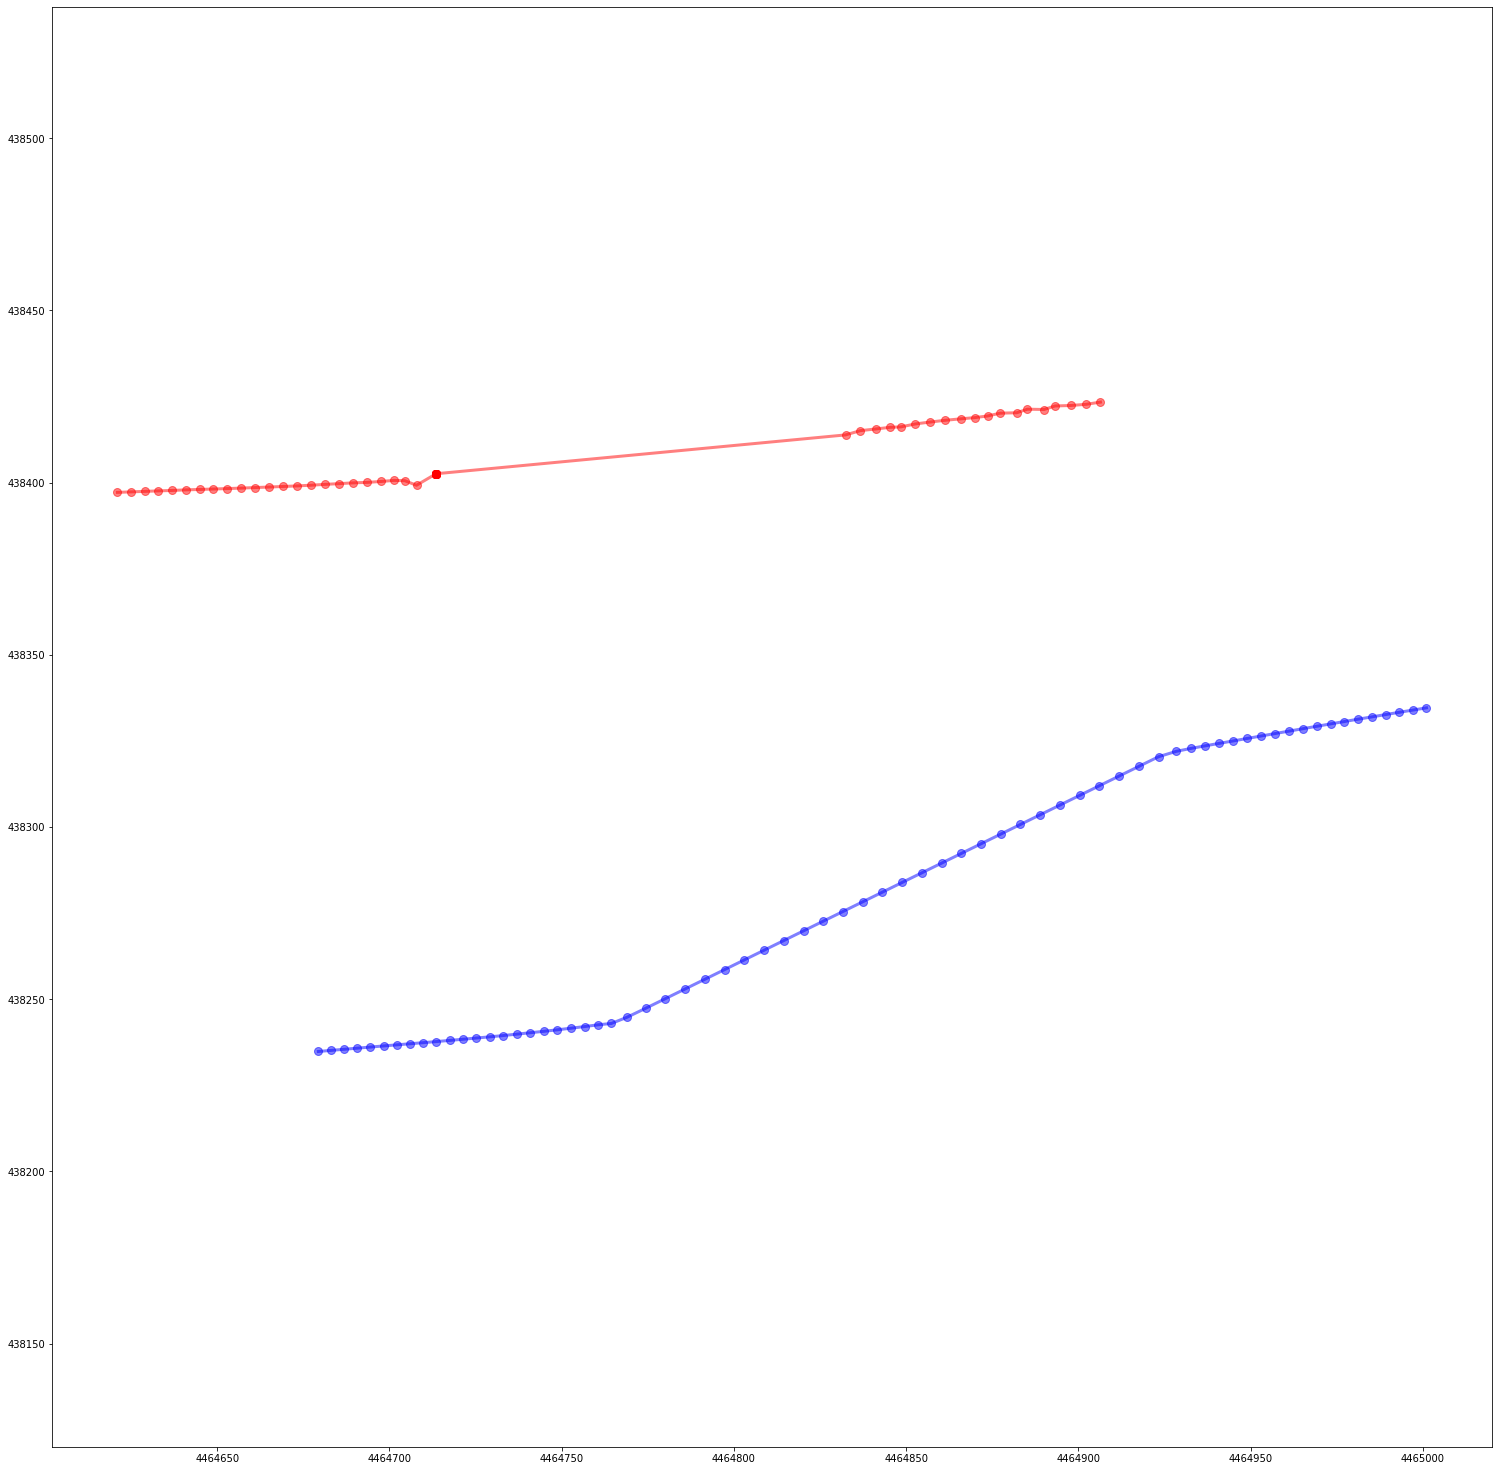

In [5]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[3420:3490]['North_Prediction(x)'],Prediction_DataFrame[3420:3490]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[3420:3490]['North'],Pos_DataFrame[3420:3490]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

In [19]:
Pos_DataFrame.iloc[3430:3490]

,North,East,Height,N_dev,E_dev,Hei_dev
3430,4.464661e+06,438398.5761,618.2238,1.3627,1.1116,2.2968
3431,4.464665e+06,438398.7296,618.1722,1.3638,1.1128,2.2990
3432,4.464669e+06,438398.8911,618.1119,1.3657,1.1141,2.3028
3433,4.464673e+06,438399.0589,618.0880,1.3670,1.1154,2.3052
3434,4.464677e+06,438399.2577,618.0481,1.3684,1.1178,2.3097
3435,4.464681e+06,438399.5047,618.0220,1.3702,1.1192,2.3127
3436,4.464685e+06,438399.7186,617.9690,1.3721,1.1201,2.3137
3437,4.464689e+06,438399.9462,617.9886,1.3732,1.1212,2.3162
3438,4.464694e+06,438400.0805,617.9398,1.5317,1.3173,2.3291
3439,4.464698e+06,438400.3556,617.9623,1.5330,1.3188,2.3314


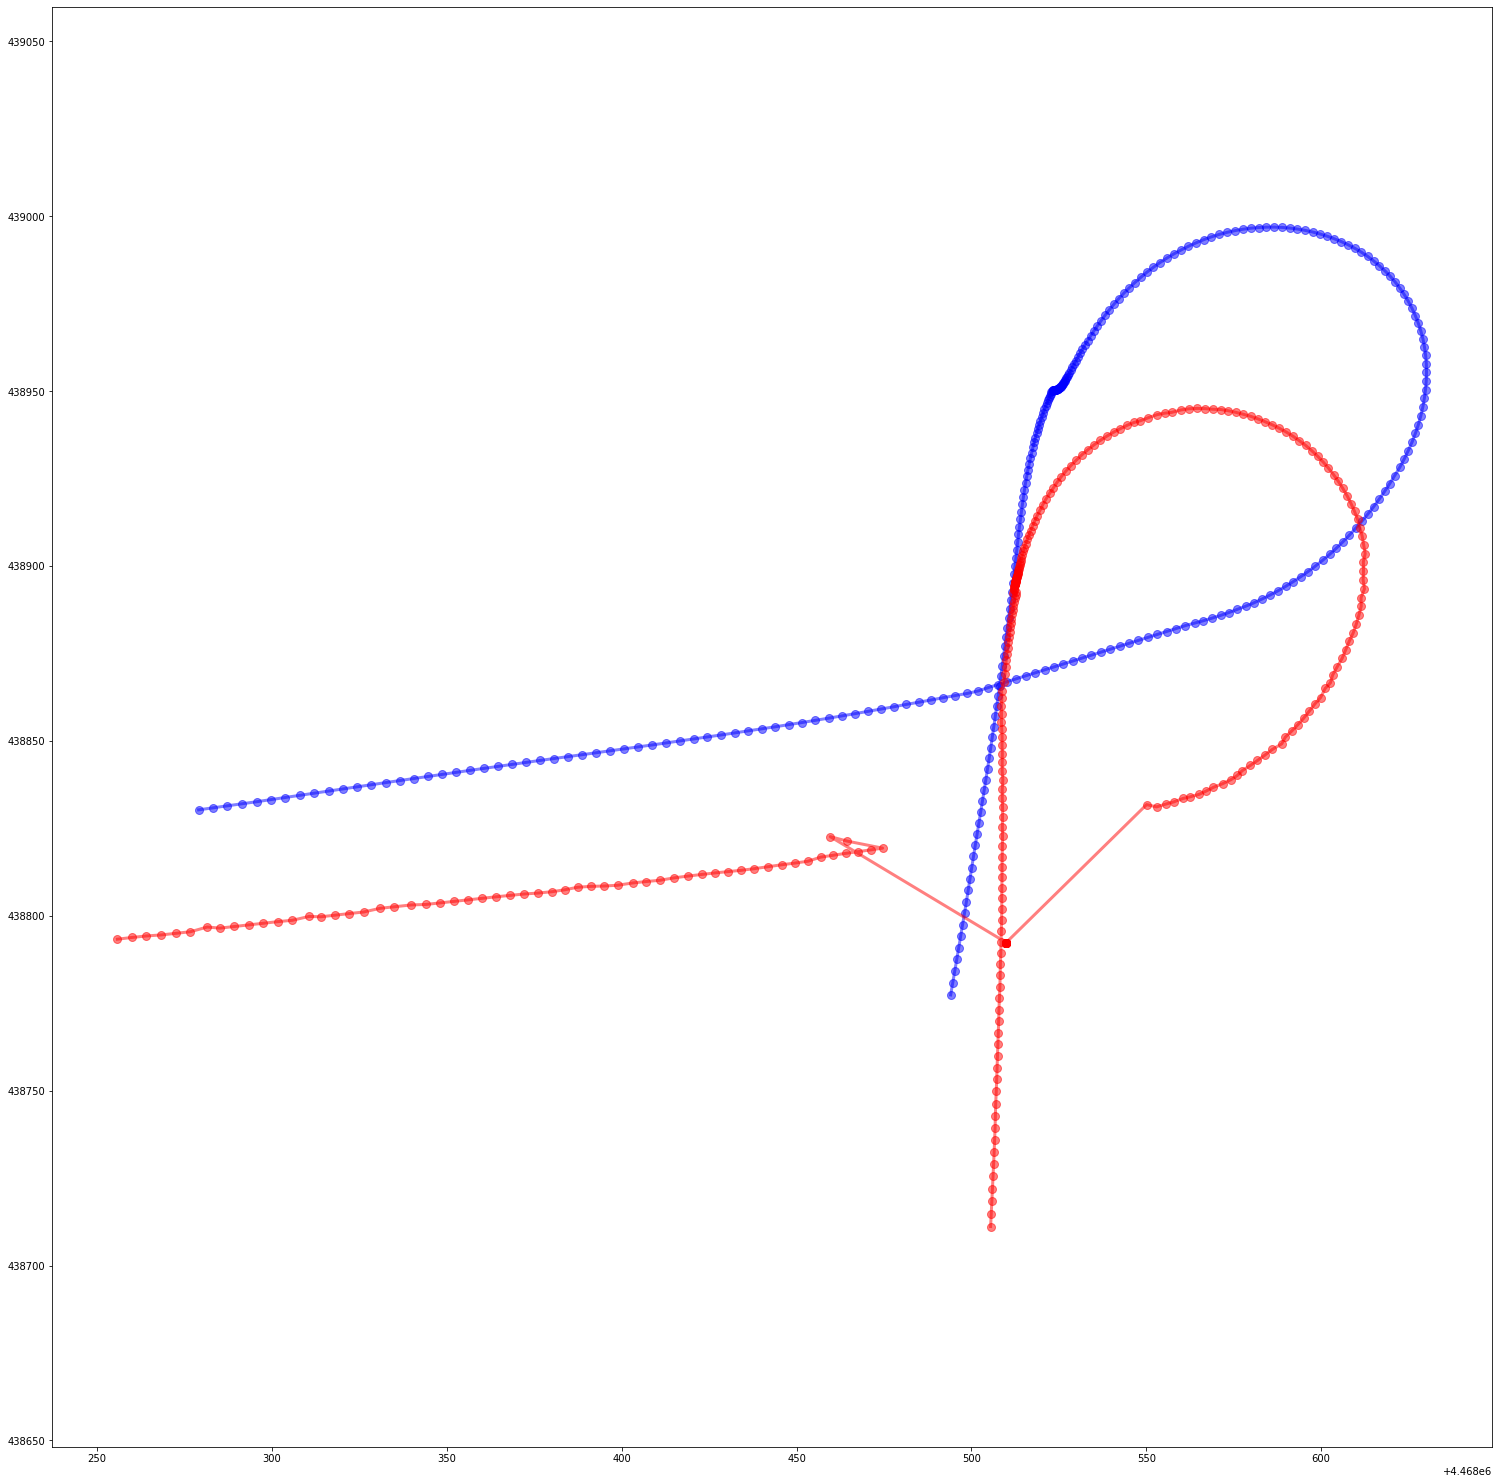

In [6]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[4300:4600]['North_Prediction(x)'],Prediction_DataFrame[4300:4600]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[4300:4600]['North'],Pos_DataFrame[4300:4600]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

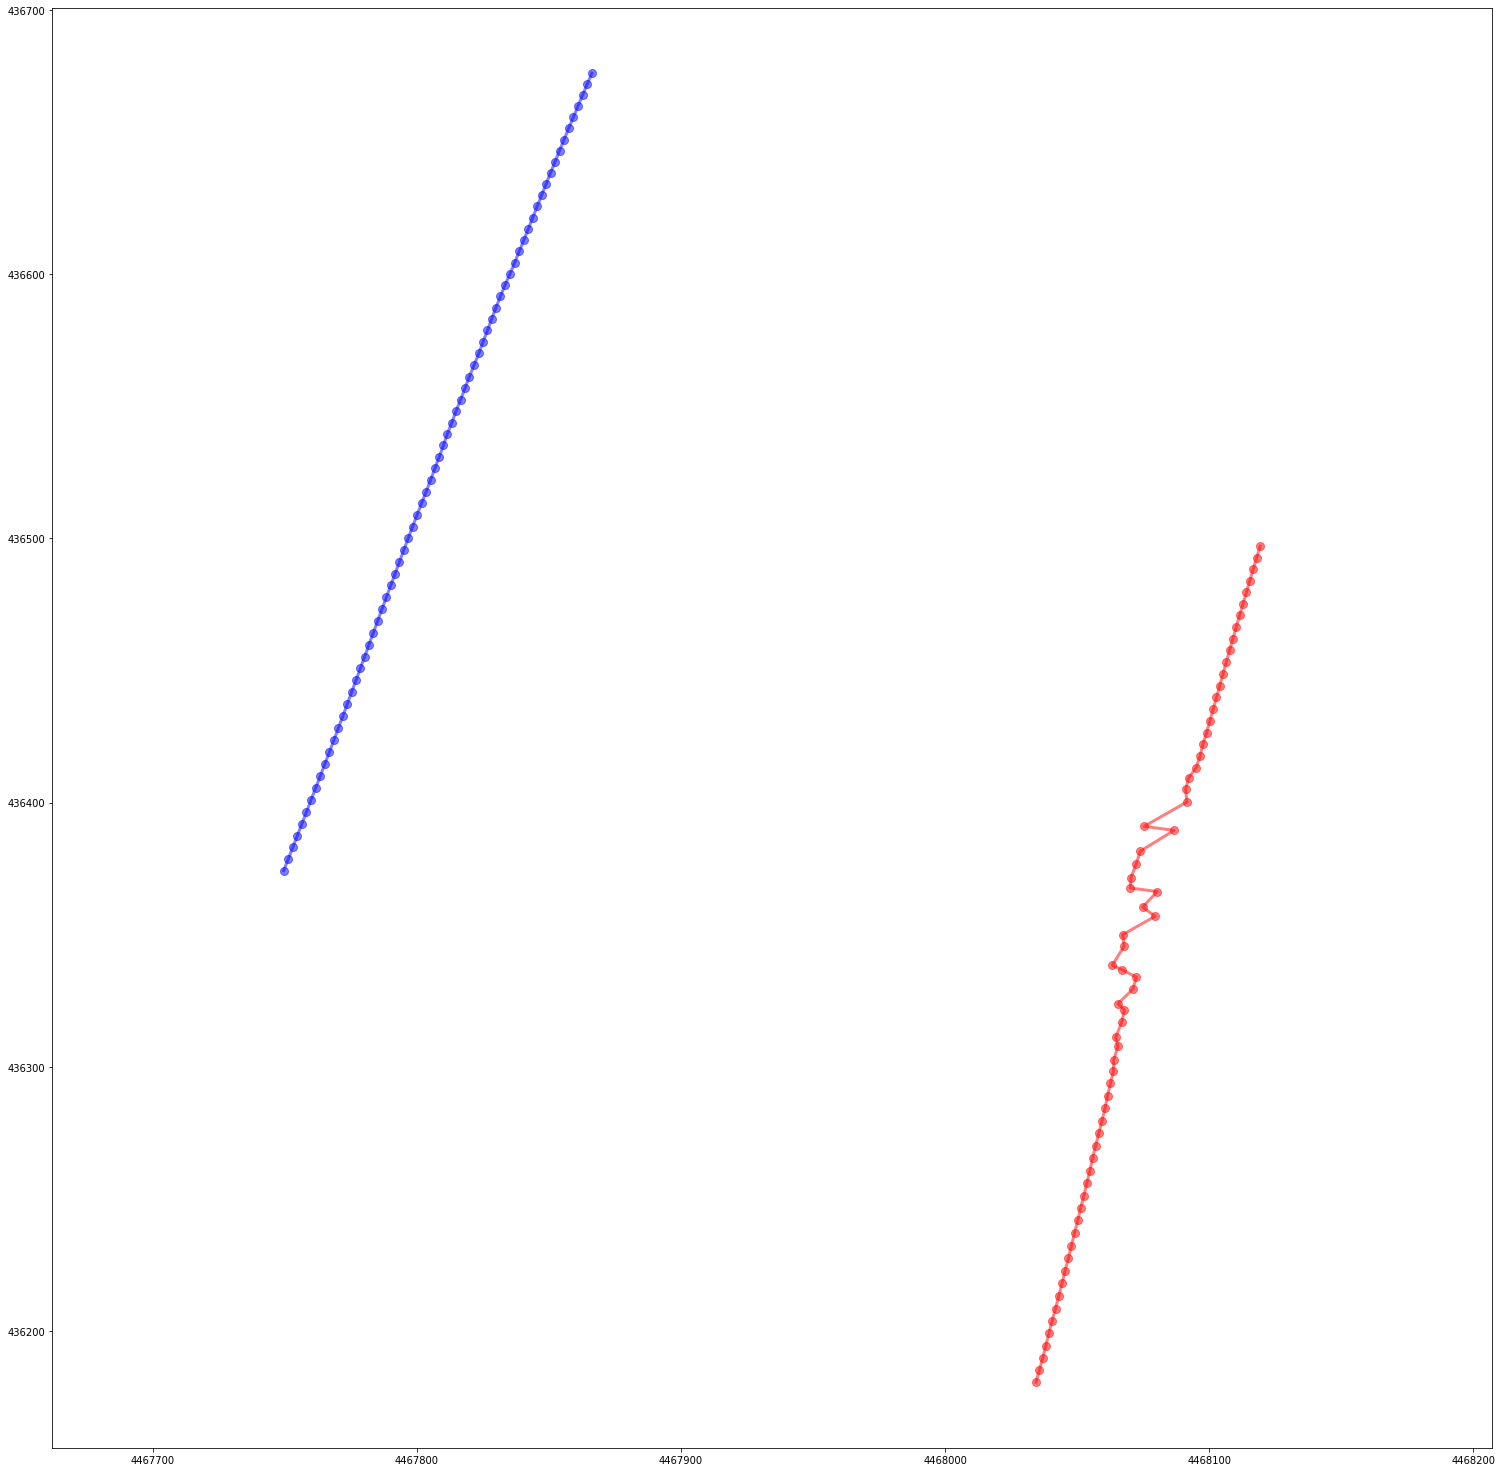

In [7]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])
ax.axis('equal')

ax.plot(Prediction_DataFrame[5115:5185]['North_Prediction(x)'],Prediction_DataFrame[5115:5185]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[5115:5185]['North'],Pos_DataFrame[5115:5185]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

In [22]:
Pos_DataFrame.iloc[5115:5175]

,North,East,Height,N_dev,E_dev,Hei_dev
5115,4.468119e+06,436497.0707,636.9328,4.8811,2.9034,8.8147
5116,4.468118e+06,436492.7333,637.0252,4.8872,2.9071,8.8251
5117,4.468117e+06,436488.3616,637.0222,4.8931,2.9105,8.8354
5118,4.468115e+06,436483.9881,636.9620,4.8989,2.9140,8.8463
5119,4.468114e+06,436479.5730,637.0595,4.9050,2.9176,8.8575
5120,4.468113e+06,436475.2128,637.1675,4.9112,2.9210,8.8685
5121,4.468111e+06,436470.8368,637.2716,4.9173,2.9245,8.8803
5122,4.468110e+06,436466.4153,637.3568,4.9237,2.9283,8.8914
5123,4.468109e+06,436462.0021,637.4815,4.9296,2.9317,8.9019
5124,4.468108e+06,436457.5901,637.5879,4.9356,2.9355,8.9133


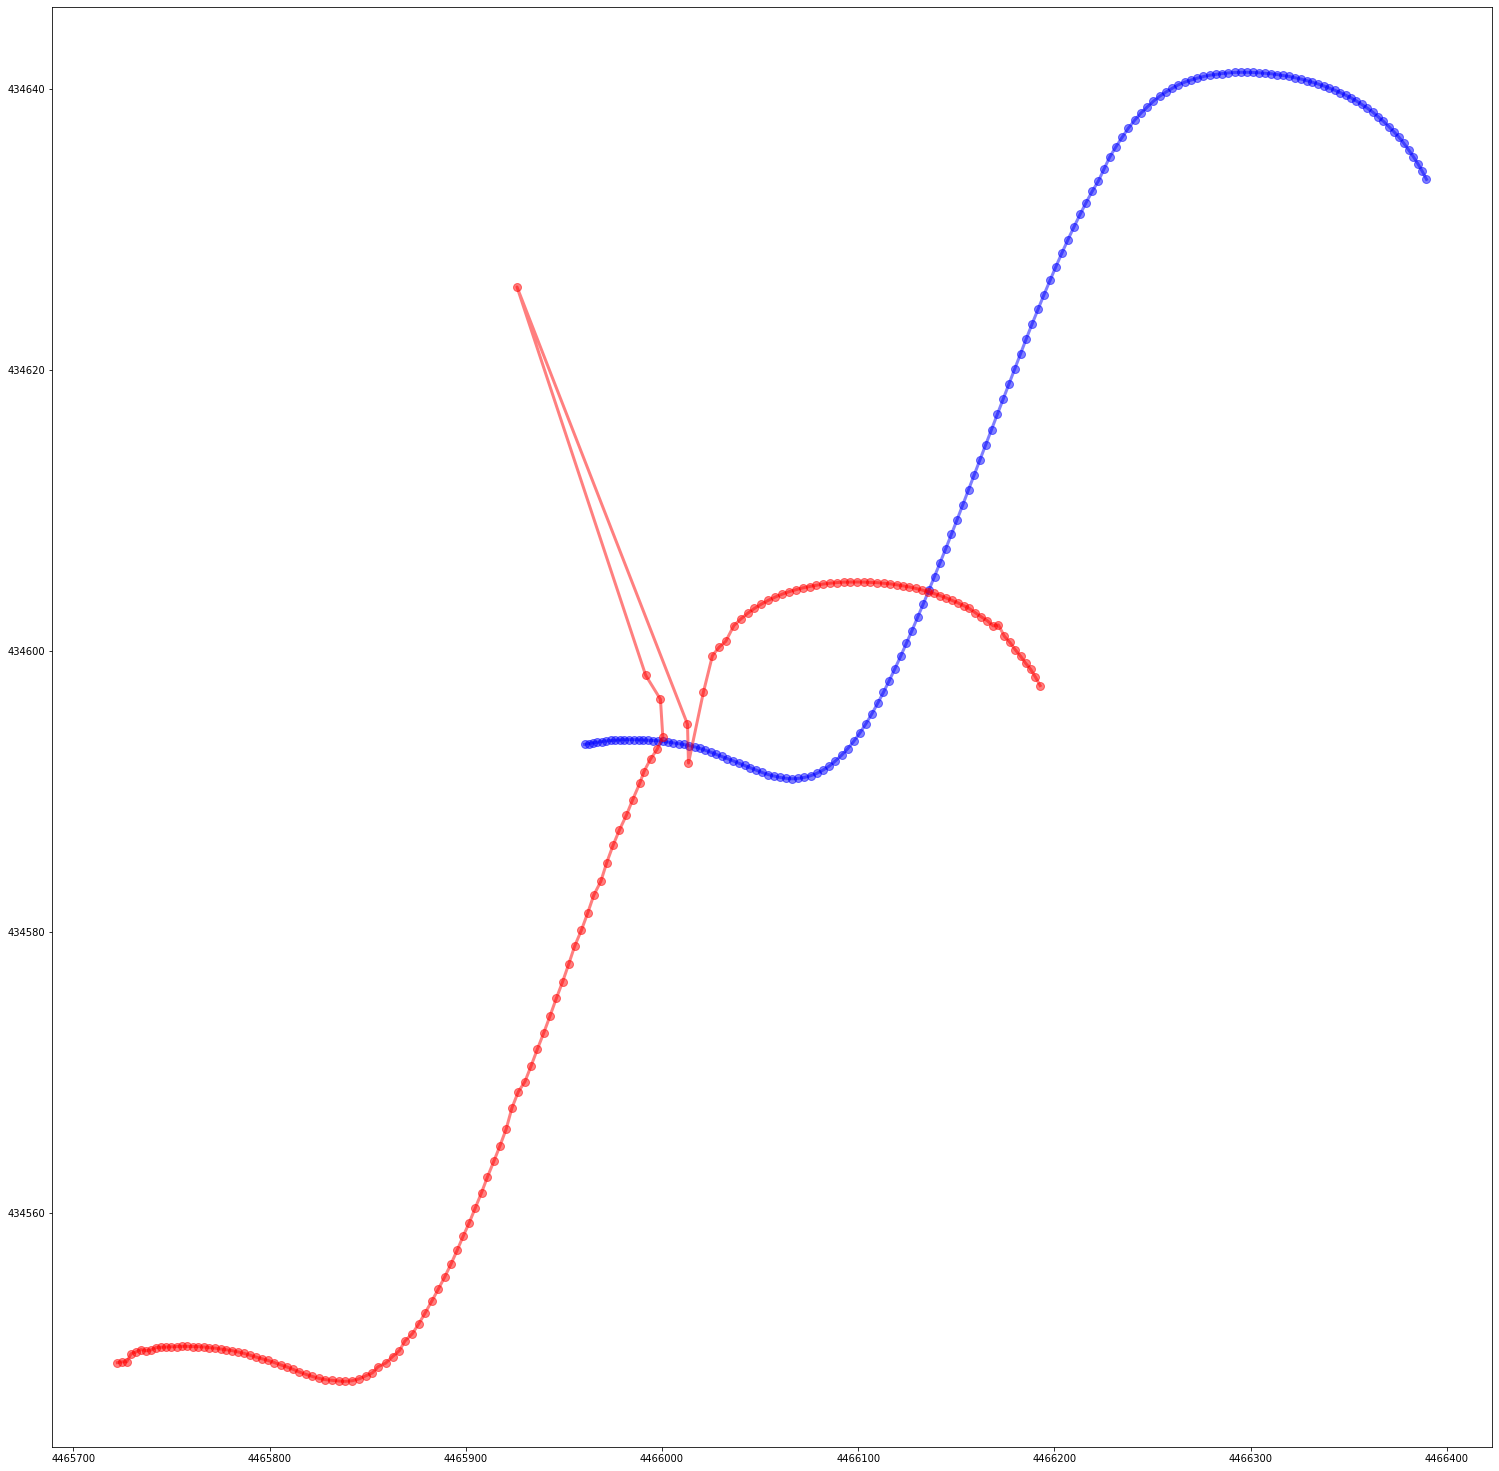

In [45]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_axes([0,0,1,1])

ax.plot(Prediction_DataFrame[7050:7200]['North_Prediction(x)'],Prediction_DataFrame[7050:7200]['South_Prediction(y)'],color='blue',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Prediction')
ax.plot(Pos_DataFrame[7050:7200]['North'],Pos_DataFrame[7050:7200]['East'],color='red',linewidth=3,alpha=0.5,
        marker='o',markersize=8,label='Data')

In [49]:
Pos_DataFrame.iloc[7070:7200]

,North,East,Height,N_dev,E_dev,Hei_dev
7070,4.466136e+06,434604.2148,653.9572,3.3723,2.8162,6.4854
7071,4.466132e+06,434604.3341,654.0457,3.3767,2.8203,6.4939
7072,4.466129e+06,434604.4470,654.1705,3.3811,2.8244,6.5025
7073,4.466126e+06,434604.5475,654.3268,3.3870,2.8285,6.5143
7074,4.466123e+06,434604.6254,654.4233,3.4020,2.8330,6.5452
...,...,...,...,...,...,...
7195,4.465732e+06,434550.1051,670.2321,4.0088,3.3288,7.5797
7196,4.465729e+06,434549.9852,670.4185,4.0134,3.3258,7.5470
7197,4.465727e+06,434549.4105,672.2898,4.0144,3.2633,7.1674
7198,4.465725e+06,434549.4056,672.0651,4.0199,3.2675,7.1771
